The purpose of this notebook is to evaluate GPDs $G_q(x,\eta,t)$ as well as their conformal moments $\mathbb{G}_q(n,\eta,t)$, where, for a generic GPD, we have its conformal moment expansion
\begin{equation}
G_q(x,\eta,t)=\sum_{n=0}^\infty (-1)^{n}p_n(x,\eta)\mathbb{F}_q(n,\eta,t),\qquad G_g(x,\eta,t)=\sum_{n=1}^\infty (-1)^{n-1}\, {^g\!p}_n(x,\eta) \mathbb{G}_g(n,\eta,t),
\end{equation}
where $G=H,E,\widetilde{H},\widetilde{E},H^T,E^T,\widetilde{H}^T,\widetilde{E}^T$.

To this end, we utilize the MSTW (AAC) unpolarized (polarized) PDF parametrization as input. The conformal moments are obtained by Reggeized $x$ integrals over PDFs at some input scale $\mu_0=1$ GeV and evolved using the pertinent RGEs, currently up to next-to-leading order. The GPDs are reconstructed using the expansion in conformal partial waves and Mellin-Barnes integrals to resum the expansion in conformal moments and partial waves.

Plots of conformal moments $\mathbb{G}(n,\eta,t)$ in momentum space

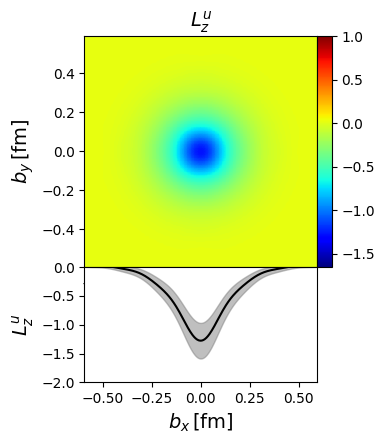

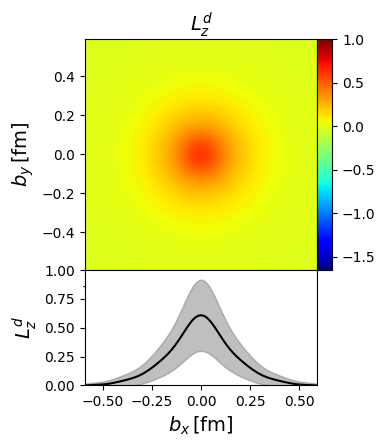

In [1]:
from stringy_gpds.plot import plot_fourier_transform_quark_orbital_angular_momentum
plot_fourier_transform_quark_orbital_angular_momentum(0,2,moment_type="u",vmin=1,vmax=-1.5,ymin=-2,ymax=0)
plot_fourier_transform_quark_orbital_angular_momentum(0,2,moment_type="d",vmin=1,vmax=-1.5,ymin=0,ymax=1)

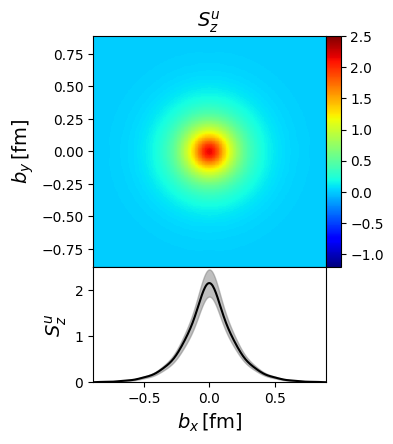

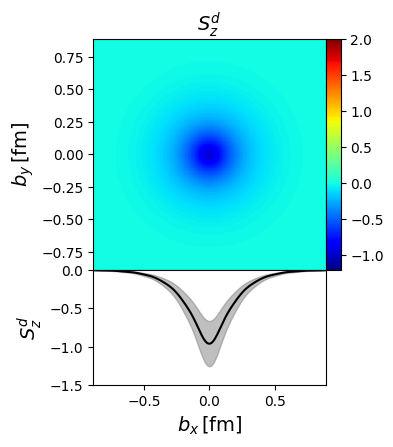

In [2]:
from stringy_gpds.plot import plot_fourier_transform_quark_helicity
plot_fourier_transform_quark_helicity(0,2,moment_type="u",vmin=-1.2,vmax=2.5,ymin=0,ymax=2.5)
plot_fourier_transform_quark_helicity(0,2,moment_type="d",vmin=-1.2,vmax=2,ymin=-1.5,ymax=0)

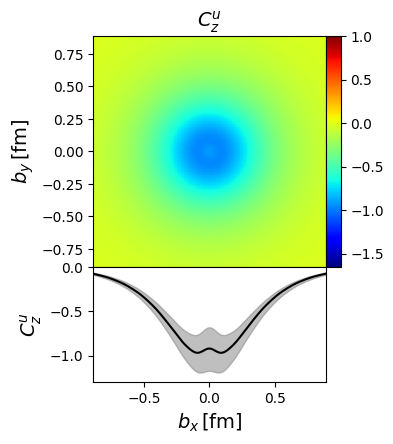

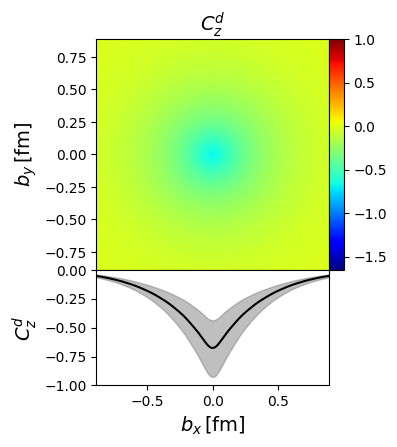

In [3]:
from stringy_gpds.plot import plot_fourier_transform_quark_spin_orbit_correlation
plot_fourier_transform_quark_spin_orbit_correlation(0,2,moment_type="u",vmin=1,vmax=-1.5,ymin=-1.3,ymax=0)
plot_fourier_transform_quark_spin_orbit_correlation(0,2,moment_type="d",vmin=1,vmax=-1.5,ymin=-1,ymax=0)

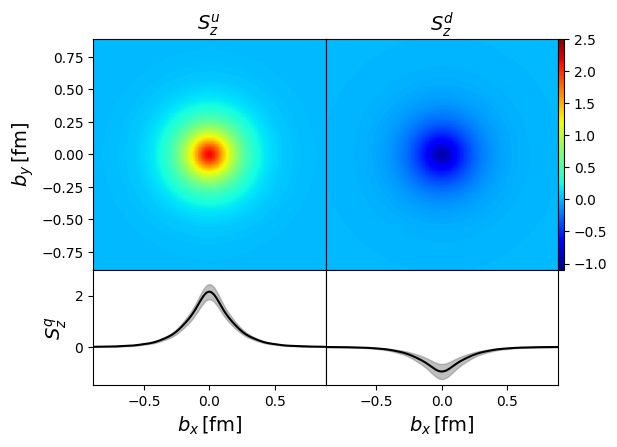

In [8]:
import stringy_gpds.core as core
import stringy_gpds.config as cfg
import stringy_gpds.helpers as hp
import numpy as np
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from scipy.interpolate import RectBivariateSpline

def plot_fourier_transform_ud_helicity(eta, mu,
                                       b_max=4.5, interpolation = True,n_int=300,
                                       vmin = -1.1 , vmax = 2.5, ymin = -0.5, ymax = 2.5,
                                       plot_option="both"):
    """
    Generate a 2D density plot of the quark helicity in impact parameter space.

    Parameters
    ----------
    eta : float
        Skewness parameter.
    mu : float
        Resolution scale in GeV.
    moment_type : str, optional
        "non_singlet_isovector", "non_singlet_isoscalar", or "singlet".
    evolution_order : str, optional
        "lo", "nlo",... . Default is "nlo".
    b_max : float, optional
        Maximum value of impact parameter in Gev^-1 used for the plot.
    Delta_max : float, optional
        Upper bound for the momentum magnitude in the integration. Default is 5 GeV.
    n_b : int, optional
        Number of points for discretizing the transverse position plane. Default is 100.
    interpolation : bool, optional
        Whether to interpolate data to plot on a finer grid. Default is True.
    n_int : int, optional
        Number of interpolation points. Default is 300.
    vmin : float, optional
        Minimum value of the colorbar. Default is 0.
    vmax : float, optional
        Maximum value of the colorbar. Default is 1.
    ymin : float, optional
        Minimum value on y-axis used in by = 0 slice of lower plot.
    ymax : float, optional
        Maximum value on y-axis used in by = 0 slice of lower plot.   
    plot_option : str, optional
        Either "lower" (only by = 0 slice) or "both" (Density plot and by = 0 slice)
    write_to_file : bool, optional
        Whether to save the computed data to the file system. Default is False.
    read_from_file : bool, optional
        Whether to load data from file system if available. Default is True.

    Returns
    -------
    None

    Notes
    -----
    This function creates a 2D density plot of the Fourier-transformed quark helicity.

    The plot is saved under
    cfg.PLOT_PATH / f"imp_param_helicity_{moment_type}.pdf" where 
    PLOT_PATH is defined in config.py

    If write_to_file is set to true the data is saved under 
    cfg.IMPACT_PARAMETER_MOMENTS_PATH / f"imp_param_helicity_{mom_type}.csv"
    where IMPACT_PARAMETER_MOMENTS_PATH is defined in config.py
    """ 
    prfx = f"imp_param_helicity_ud"
    file_name = hp.generate_filename(eta,0,mu,prfx,file_ext="pdf")
    FILE_PATH = cfg.PLOT_PATH / file_name
    hbarc = 0.1975
    moment_types = ["u","d"]

    # Determine figure layout
    fig, axs = plt.subplots(2, 2, figsize=(2*3, 4.5), gridspec_kw={'height_ratios': [2, 1], 'hspace': 0})

    for i, mom_type in enumerate(moment_types):
        READ_WRITE_PATH = cfg.IMPACT_PARAMETER_MOMENTS_PATH / f"imp_param_helicity_{mom_type}"
        row, col = divmod(i, 2)  # Map index to subplot location
        ax = axs[0, col]
        ax_lower = axs[1, col]

        file_name = hp.generate_filename(eta,0,mu,READ_WRITE_PATH,"central")
        b_x_fm, b_y_fm, fourier_transform_moment_values_flat = hp.read_ft_from_csv(file_name)
        file_name = hp.generate_filename(eta,0,mu,READ_WRITE_PATH,"plus")
        _, _, fourier_transform_moment_values_flat_plus = hp.read_ft_from_csv(file_name)
        file_name = hp.generate_filename(eta,0,mu,READ_WRITE_PATH,"minus")
        _, _, fourier_transform_moment_values_flat_minus = hp.read_ft_from_csv(file_name)

        if interpolation:
            ft_interpolation = RectBivariateSpline(b_x_fm, b_y_fm, fourier_transform_moment_values_flat)
            ft_interpolation_plus = RectBivariateSpline(b_x_fm, b_y_fm, fourier_transform_moment_values_flat_plus)
            ft_interpolation_minus = RectBivariateSpline(b_x_fm, b_y_fm, fourier_transform_moment_values_flat_minus)

            # Call the interpolation on a finer grid
            b_x = np.linspace(-b_max, b_max, n_int)
            b_y = np.linspace(-b_max, b_max, n_int)
            b_x_fm = b_x * hbarc
            b_y_fm = b_y * hbarc

            fourier_transform_moment_values_flat = ft_interpolation(b_x_fm, b_y_fm)
            fourier_transform_moment_values_flat_plus = ft_interpolation_plus(b_x_fm, b_y_fm)
            fourier_transform_moment_values_flat_minus = ft_interpolation_minus(b_x_fm, b_y_fm)

        # Upper plot: 2D density plot
        if plot_option in ["upper", "both"]:
            im = ax.pcolormesh(b_x_fm, b_y_fm, fourier_transform_moment_values_flat, 
                               shading='auto', cmap='jet', vmin=vmin, vmax=vmax,rasterized=True)
            ax.set_xlabel(r'$b_x\,[\mathrm{fm}]$', fontsize=14)
            if i == 0:
                ax.set_ylabel(r'$b_y\,[\mathrm{fm}]$', fontsize=14)
            ax.set_title(rf"$S_z^{{{moment_types[i]}}}$", fontsize=14)
            ax.set_xlim([-b_max * hbarc, b_max * hbarc])
            ax.set_ylim([-b_max * hbarc, b_max * hbarc])

            # Add colorbar only once per row
            if col == 2-1:
                cbar_ax = fig.add_axes([ax.get_position().x1, ax.get_position().y0, 0.01, ax.get_position().height])
                fig.colorbar(im, cax=cbar_ax)

        # Lower plot: 1D slice at b_y = 0
        if plot_option in ["lower", "both"]:
            idx_by_0 = np.argmin(np.abs(b_y))
            ax_lower.plot(b_x_fm, fourier_transform_moment_values_flat[idx_by_0, :], color='black')
            ax_lower.fill_between(b_x_fm, 
                                  fourier_transform_moment_values_flat_minus[idx_by_0, :], 
                                  fourier_transform_moment_values_flat_plus[idx_by_0, :], 
                                  color='gray', alpha=0.5)
            ax_lower.set_xlabel(r'$b_x\,[\mathrm{fm}]$', fontsize=14)
            ax_lower.set_xlim([-b_max * hbarc, b_max * hbarc])
            ax_lower.set_ylim([ymin, ymax])

            if i == 0:
                ax_lower.set_ylabel(rf'$S_z^{{q}}$', fontsize=14)
            # Remove ticks and labels
            if i != 0:
                ax.set_yticks([])
                ax.set_yticklabels([])
                ax.set_ylabel(None)

                ax_lower.set_yticks([])
                ax_lower.set_yticklabels([])
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.savefig(FILE_PATH,format="pdf",bbox_inches="tight",dpi=600)

    # Adjust layout and show the plot
    plt.show()
    plt.close()

plot_fourier_transform_ud_helicity(0,2,ymin=-1.5,ymax = 3)

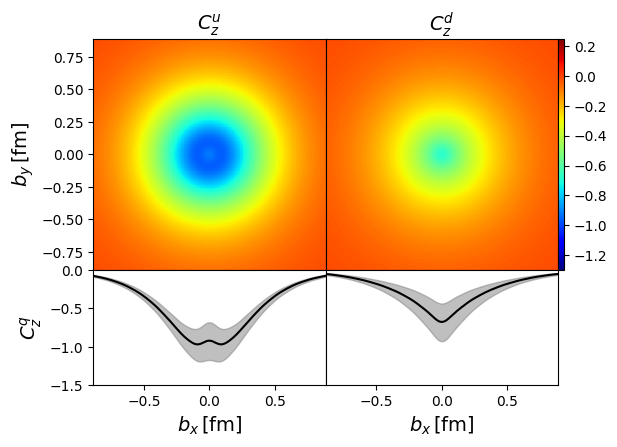

In [19]:
def plot_fourier_transform_ud_spin_orbit_correlation(eta, mu,
                                       b_max=4.5, interpolation = True,n_int=300,
                                       vmin = -1.1 , vmax = 2.5, ymin = -0.5, ymax = 2.5,
                                       plot_option="both"):
    """
    Generate a 2D density plot of the quark helicity in impact parameter space.

    Parameters
    ----------
    eta : float
        Skewness parameter.
    mu : float
        Resolution scale in GeV.
    moment_type : str, optional
        "non_singlet_isovector", "non_singlet_isoscalar", or "singlet".
    evolution_order : str, optional
        "lo", "nlo",... . Default is "nlo".
    b_max : float, optional
        Maximum value of impact parameter in Gev^-1 used for the plot.
    Delta_max : float, optional
        Upper bound for the momentum magnitude in the integration. Default is 5 GeV.
    n_b : int, optional
        Number of points for discretizing the transverse position plane. Default is 100.
    interpolation : bool, optional
        Whether to interpolate data to plot on a finer grid. Default is True.
    n_int : int, optional
        Number of interpolation points. Default is 300.
    vmin : float, optional
        Minimum value of the colorbar. Default is 0.
    vmax : float, optional
        Maximum value of the colorbar. Default is 1.
    ymin : float, optional
        Minimum value on y-axis used in by = 0 slice of lower plot.
    ymax : float, optional
        Maximum value on y-axis used in by = 0 slice of lower plot.   
    plot_option : str, optional
        Either "lower" (only by = 0 slice) or "both" (Density plot and by = 0 slice)
    write_to_file : bool, optional
        Whether to save the computed data to the file system. Default is False.
    read_from_file : bool, optional
        Whether to load data from file system if available. Default is True.

    Returns
    -------
    None

    Notes
    -----
    This function creates a 2D density plot of the Fourier-transformed quark helicity.

    The plot is saved under
    cfg.PLOT_PATH / f"imp_param_helicity_{moment_type}.pdf" where 
    PLOT_PATH is defined in config.py

    If write_to_file is set to true the data is saved under 
    cfg.IMPACT_PARAMETER_MOMENTS_PATH / f"imp_param_helicity_{mom_type}.csv"
    where IMPACT_PARAMETER_MOMENTS_PATH is defined in config.py
    """ 
    prfx = f"imp_param_spin_orbit_ud"
    file_name = hp.generate_filename(eta,0,mu,prfx,file_ext="pdf")
    FILE_PATH = cfg.PLOT_PATH / file_name
    hbarc = 0.1975
    moment_types = ["u","d"]

    # Determine figure layout
    fig, axs = plt.subplots(2, 2, figsize=(2*3, 4.5), gridspec_kw={'height_ratios': [2, 1], 'hspace': 0})

    for i, mom_type in enumerate(moment_types):
        READ_WRITE_PATH = cfg.IMPACT_PARAMETER_MOMENTS_PATH / f"imp_param_spin_orbit_{mom_type}"
        row, col = divmod(i, 2)  # Map index to subplot location
        ax = axs[0, col]
        ax_lower = axs[1, col]

        file_name = hp.generate_filename(eta,0,mu,READ_WRITE_PATH,"central")
        b_x_fm, b_y_fm, fourier_transform_moment_values_flat = hp.read_ft_from_csv(file_name)
        file_name = hp.generate_filename(eta,0,mu,READ_WRITE_PATH,"plus")
        _, _, fourier_transform_moment_values_flat_plus = hp.read_ft_from_csv(file_name)
        file_name = hp.generate_filename(eta,0,mu,READ_WRITE_PATH,"minus")
        _, _, fourier_transform_moment_values_flat_minus = hp.read_ft_from_csv(file_name)

        if interpolation:
            ft_interpolation = RectBivariateSpline(b_x_fm, b_y_fm, fourier_transform_moment_values_flat)
            ft_interpolation_plus = RectBivariateSpline(b_x_fm, b_y_fm, fourier_transform_moment_values_flat_plus)
            ft_interpolation_minus = RectBivariateSpline(b_x_fm, b_y_fm, fourier_transform_moment_values_flat_minus)

            # Call the interpolation on a finer grid
            b_x = np.linspace(-b_max, b_max, n_int)
            b_y = np.linspace(-b_max, b_max, n_int)
            b_x_fm = b_x * hbarc
            b_y_fm = b_y * hbarc

            fourier_transform_moment_values_flat = ft_interpolation(b_x_fm, b_y_fm)
            fourier_transform_moment_values_flat_plus = ft_interpolation_plus(b_x_fm, b_y_fm)
            fourier_transform_moment_values_flat_minus = ft_interpolation_minus(b_x_fm, b_y_fm)

        # Upper plot: 2D density plot
        if plot_option in ["upper", "both"]:
            im = ax.pcolormesh(b_x_fm, b_y_fm, fourier_transform_moment_values_flat, 
                               shading='auto', cmap='jet', vmin=vmin, vmax=vmax,rasterized=True)
            ax.set_xlabel(r'$b_x\,[\mathrm{fm}]$', fontsize=14)
            if i == 0:
                ax.set_ylabel(r'$b_y\,[\mathrm{fm}]$', fontsize=14)
            ax.set_title(rf"$C_z^{{{moment_types[i]}}}$", fontsize=14)
            ax.set_xlim([-b_max * hbarc, b_max * hbarc])
            ax.set_ylim([-b_max * hbarc, b_max * hbarc])

            # Add colorbar only once per row
            if col == 2-1:
                cbar_ax = fig.add_axes([ax.get_position().x1, ax.get_position().y0, 0.01, ax.get_position().height])
                fig.colorbar(im, cax=cbar_ax)

        # Lower plot: 1D slice at b_y = 0
        if plot_option in ["lower", "both"]:
            idx_by_0 = np.argmin(np.abs(b_y))
            ax_lower.plot(b_x_fm, fourier_transform_moment_values_flat[idx_by_0, :], color='black')
            ax_lower.fill_between(b_x_fm, 
                                  fourier_transform_moment_values_flat_minus[idx_by_0, :], 
                                  fourier_transform_moment_values_flat_plus[idx_by_0, :], 
                                  color='gray', alpha=0.5)
            ax_lower.set_xlabel(r'$b_x\,[\mathrm{fm}]$', fontsize=14)
            ax_lower.set_xlim([-b_max * hbarc, b_max * hbarc])
            ax_lower.set_ylim([ymin, ymax])

            if i == 0:
                ax_lower.set_ylabel(rf'$C_z^{{q}}$', fontsize=14)
            # Remove ticks and labels
            if i != 0:
                ax.set_yticks([])
                ax.set_yticklabels([])
                ax.set_ylabel(None)

                ax_lower.set_yticks([])
                ax_lower.set_yticklabels([])
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.savefig(FILE_PATH,format="pdf",bbox_inches="tight",dpi=600)

    # Adjust layout and show the plot
    plt.show()
    plt.close()

plot_fourier_transform_ud_spin_orbit_correlation(0,2,ymin=-1.5,ymax = 0,vmin=-1.3,vmax=.25)

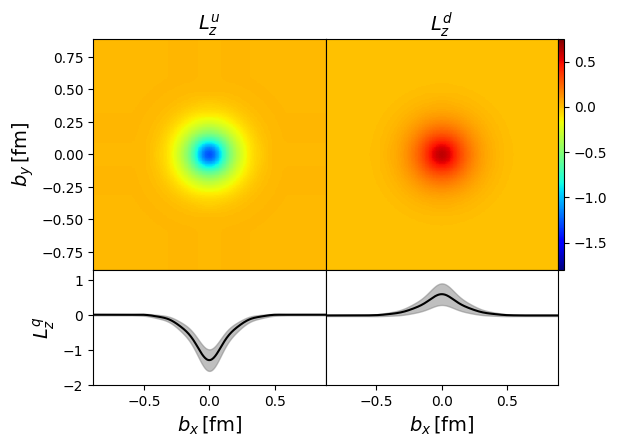

In [21]:
def plot_fourier_transform_ud_spin_orbit_correlation(eta, mu,
                                       b_max=4.5, interpolation = True,n_int=300,
                                       vmin = -1.1 , vmax = 2.5, ymin = -0.5, ymax = 2.5,
                                       plot_option="both"):
    """
    Generate a 2D density plot of the quark helicity in impact parameter space.

    Parameters
    ----------
    eta : float
        Skewness parameter.
    mu : float
        Resolution scale in GeV.
    moment_type : str, optional
        "non_singlet_isovector", "non_singlet_isoscalar", or "singlet".
    evolution_order : str, optional
        "lo", "nlo",... . Default is "nlo".
    b_max : float, optional
        Maximum value of impact parameter in Gev^-1 used for the plot.
    Delta_max : float, optional
        Upper bound for the momentum magnitude in the integration. Default is 5 GeV.
    n_b : int, optional
        Number of points for discretizing the transverse position plane. Default is 100.
    interpolation : bool, optional
        Whether to interpolate data to plot on a finer grid. Default is True.
    n_int : int, optional
        Number of interpolation points. Default is 300.
    vmin : float, optional
        Minimum value of the colorbar. Default is 0.
    vmax : float, optional
        Maximum value of the colorbar. Default is 1.
    ymin : float, optional
        Minimum value on y-axis used in by = 0 slice of lower plot.
    ymax : float, optional
        Maximum value on y-axis used in by = 0 slice of lower plot.   
    plot_option : str, optional
        Either "lower" (only by = 0 slice) or "both" (Density plot and by = 0 slice)
    write_to_file : bool, optional
        Whether to save the computed data to the file system. Default is False.
    read_from_file : bool, optional
        Whether to load data from file system if available. Default is True.

    Returns
    -------
    None

    Notes
    -----
    This function creates a 2D density plot of the Fourier-transformed quark helicity.

    The plot is saved under
    cfg.PLOT_PATH / f"imp_param_helicity_{moment_type}.pdf" where 
    PLOT_PATH is defined in config.py

    If write_to_file is set to true the data is saved under 
    cfg.IMPACT_PARAMETER_MOMENTS_PATH / f"imp_param_helicity_{mom_type}.csv"
    where IMPACT_PARAMETER_MOMENTS_PATH is defined in config.py
    """ 
    prfx = f"imp_param_oam_ud"
    file_name = hp.generate_filename(eta,0,mu,prfx,file_ext="pdf")
    FILE_PATH = cfg.PLOT_PATH / file_name
    hbarc = 0.1975
    moment_types = ["u","d"]

    # Determine figure layout
    fig, axs = plt.subplots(2, 2, figsize=(2*3, 4.5), gridspec_kw={'height_ratios': [2, 1], 'hspace': 0})

    for i, mom_type in enumerate(moment_types):
        READ_WRITE_PATH = cfg.IMPACT_PARAMETER_MOMENTS_PATH / f"imp_param_oam_{mom_type}" 
        row, col = divmod(i, 2)  # Map index to subplot location
        ax = axs[0, col]
        ax_lower = axs[1, col]

        file_name = hp.generate_filename(eta,0,mu,READ_WRITE_PATH,"central")
        b_x_fm, b_y_fm, fourier_transform_moment_values_flat = hp.read_ft_from_csv(file_name)
        file_name = hp.generate_filename(eta,0,mu,READ_WRITE_PATH,"plus")
        _, _, fourier_transform_moment_values_flat_plus = hp.read_ft_from_csv(file_name)
        file_name = hp.generate_filename(eta,0,mu,READ_WRITE_PATH,"minus")
        _, _, fourier_transform_moment_values_flat_minus = hp.read_ft_from_csv(file_name)

        if interpolation:
            ft_interpolation = RectBivariateSpline(b_x_fm, b_y_fm, fourier_transform_moment_values_flat)
            ft_interpolation_plus = RectBivariateSpline(b_x_fm, b_y_fm, fourier_transform_moment_values_flat_plus)
            ft_interpolation_minus = RectBivariateSpline(b_x_fm, b_y_fm, fourier_transform_moment_values_flat_minus)

            # Call the interpolation on a finer grid
            b_x = np.linspace(-b_max, b_max, n_int)
            b_y = np.linspace(-b_max, b_max, n_int)
            b_x_fm = b_x * hbarc
            b_y_fm = b_y * hbarc

            fourier_transform_moment_values_flat = ft_interpolation(b_x_fm, b_y_fm)
            fourier_transform_moment_values_flat_plus = ft_interpolation_plus(b_x_fm, b_y_fm)
            fourier_transform_moment_values_flat_minus = ft_interpolation_minus(b_x_fm, b_y_fm)

        # Upper plot: 2D density plot
        if plot_option in ["upper", "both"]:
            im = ax.pcolormesh(b_x_fm, b_y_fm, fourier_transform_moment_values_flat, 
                               shading='auto', cmap='jet', vmin=vmin, vmax=vmax,rasterized=True)
            ax.set_xlabel(r'$b_x\,[\mathrm{fm}]$', fontsize=14)
            if i == 0:
                ax.set_ylabel(r'$b_y\,[\mathrm{fm}]$', fontsize=14)
            ax.set_title(rf"$L_z^{{{moment_types[i]}}}$", fontsize=14)
            ax.set_xlim([-b_max * hbarc, b_max * hbarc])
            ax.set_ylim([-b_max * hbarc, b_max * hbarc])

            # Add colorbar only once per row
            if col == 2-1:
                cbar_ax = fig.add_axes([ax.get_position().x1, ax.get_position().y0, 0.01, ax.get_position().height])
                fig.colorbar(im, cax=cbar_ax)

        # Lower plot: 1D slice at b_y = 0
        if plot_option in ["lower", "both"]:
            idx_by_0 = np.argmin(np.abs(b_y))
            ax_lower.plot(b_x_fm, fourier_transform_moment_values_flat[idx_by_0, :], color='black')
            ax_lower.fill_between(b_x_fm, 
                                  fourier_transform_moment_values_flat_minus[idx_by_0, :], 
                                  fourier_transform_moment_values_flat_plus[idx_by_0, :], 
                                  color='gray', alpha=0.5)
            ax_lower.set_xlabel(r'$b_x\,[\mathrm{fm}]$', fontsize=14)
            ax_lower.set_xlim([-b_max * hbarc, b_max * hbarc])
            ax_lower.set_ylim([ymin, ymax])

            if i == 0:
                ax_lower.set_ylabel(rf'$L_z^{{q}}$', fontsize=14)
            # Remove ticks and labels
            if i != 0:
                ax.set_yticks([])
                ax.set_yticklabels([])
                ax.set_ylabel(None)

                ax_lower.set_yticks([])
                ax_lower.set_yticklabels([])
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.savefig(FILE_PATH,format="pdf",bbox_inches="tight",dpi=600)

    # Adjust layout and show the plot
    plt.show()
    plt.close()

plot_fourier_transform_ud_spin_orbit_correlation(0,2,ymin=-2,ymax = 1.3,vmin=-1.8,vmax=.75)

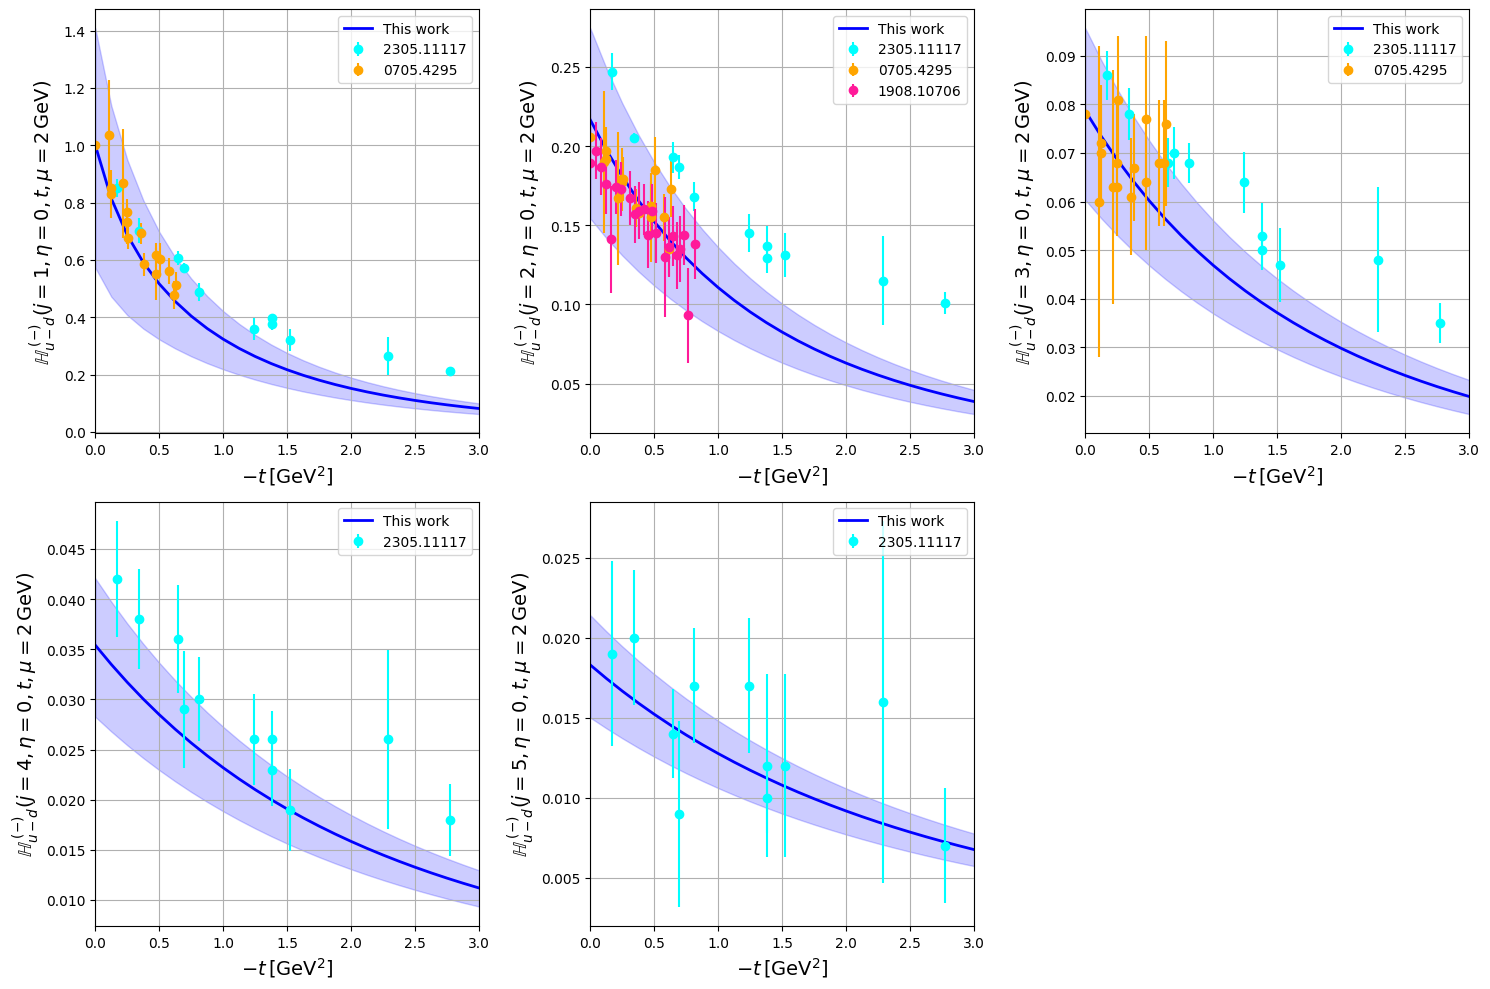

In [ ]:
from stringy_gpds import plot_moments_on_grid
#non_singlet_isovector
y_label = "$\\mathbb{{H}}_{{u-d}}^{{\,\,(-)}}$"
moment_type = "non_singlet_isovector"
moment_label = "A"

plot_moments_on_grid(0,y_label,3,1,"quark",moment_type, moment_label,"nlo",25)

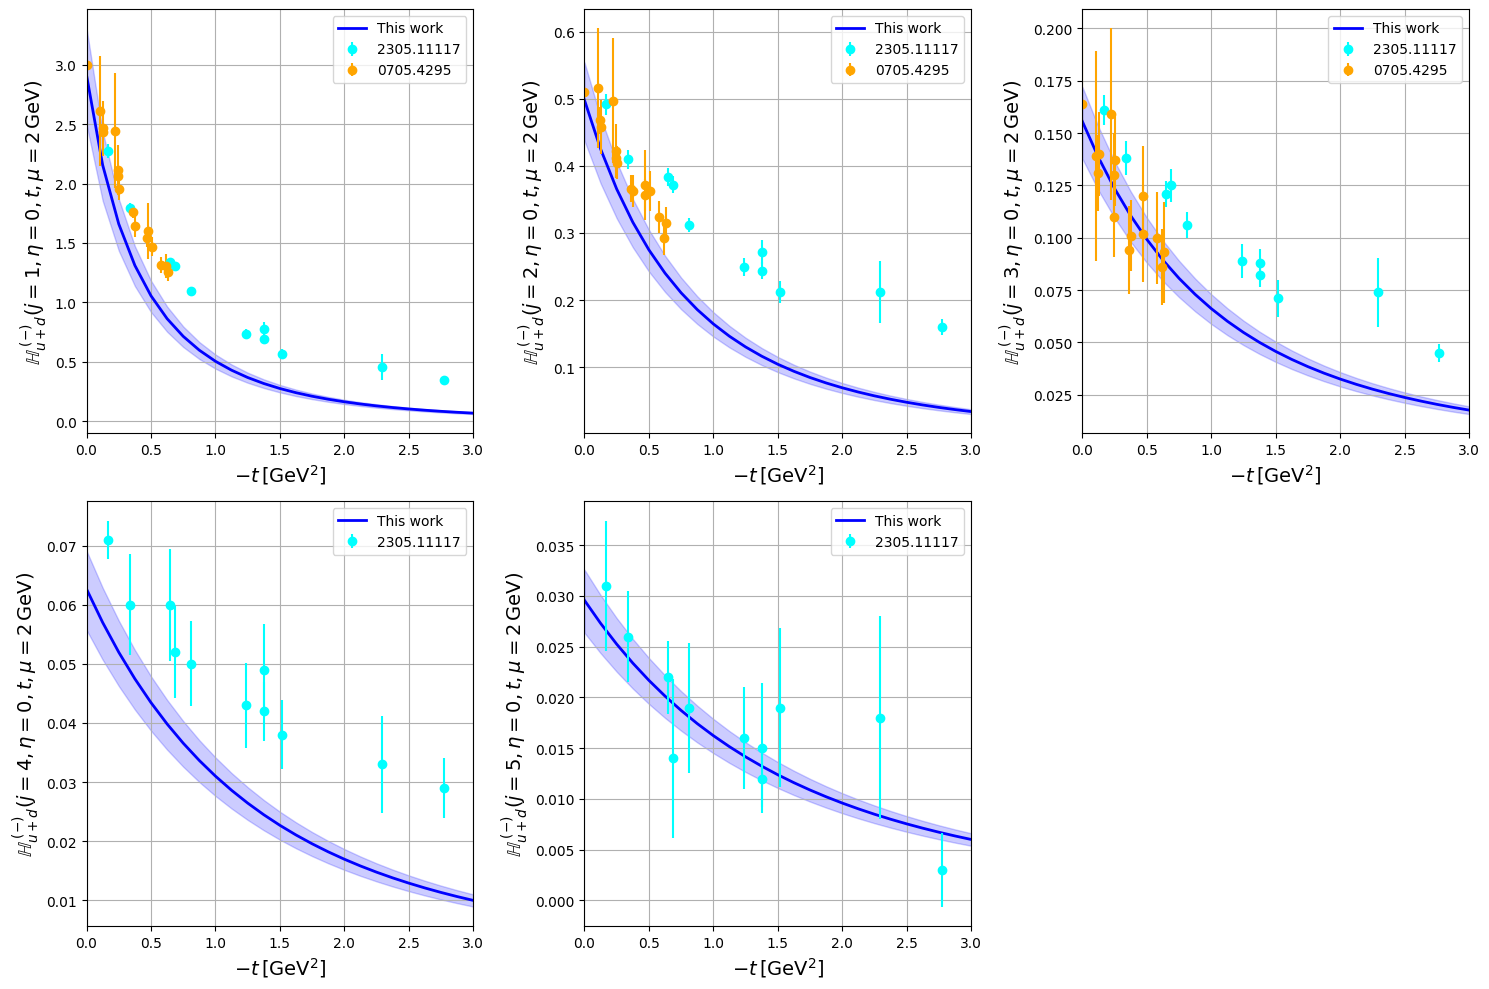

In [ ]:
# non_singlet_isoscalar
y_label = "$\\mathbb{{H}}_{{u+d}}^{{\,\,(-)}}$"
moment_type = "non_singlet_isoscalar"
moment_label = "A"

plot_moments_on_grid(0,y_label,3,1,"quark",moment_type, moment_label,"nlo",25)

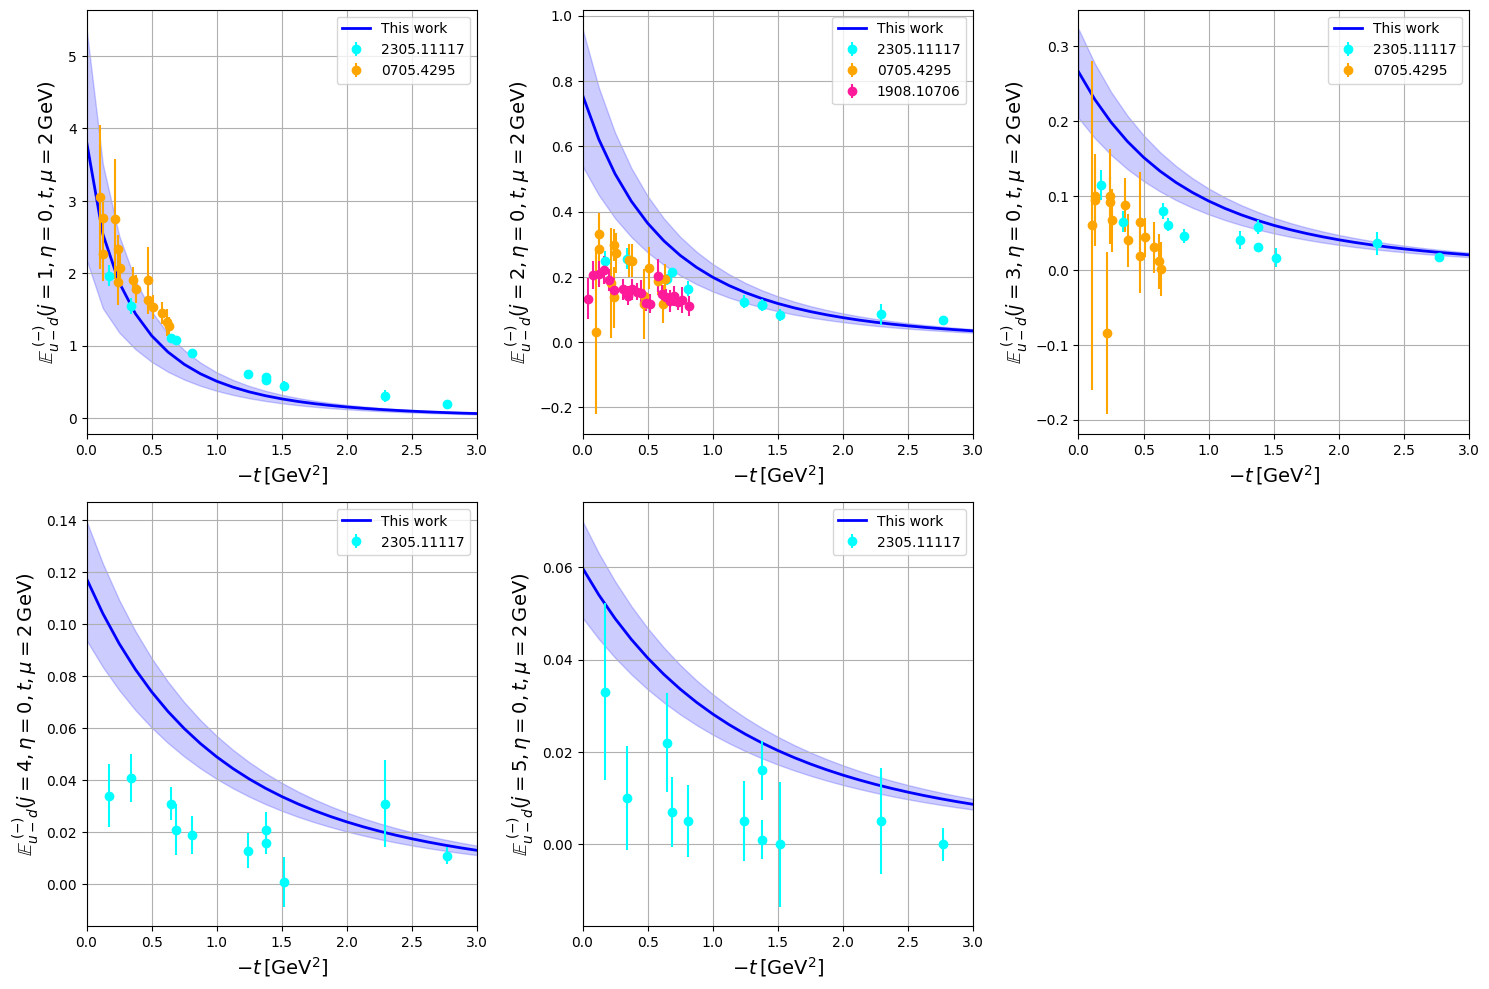

In [ ]:
#non_singlet_isovector
y_label = "$\\mathbb{{E}}_{{u-d}}^{{\,\,(-)}}$"
moment_type = "non_singlet_isovector"
moment_label = "B"

plot_moments_on_grid(0,y_label,3,1,"quark",moment_type, moment_label,"nlo",25)

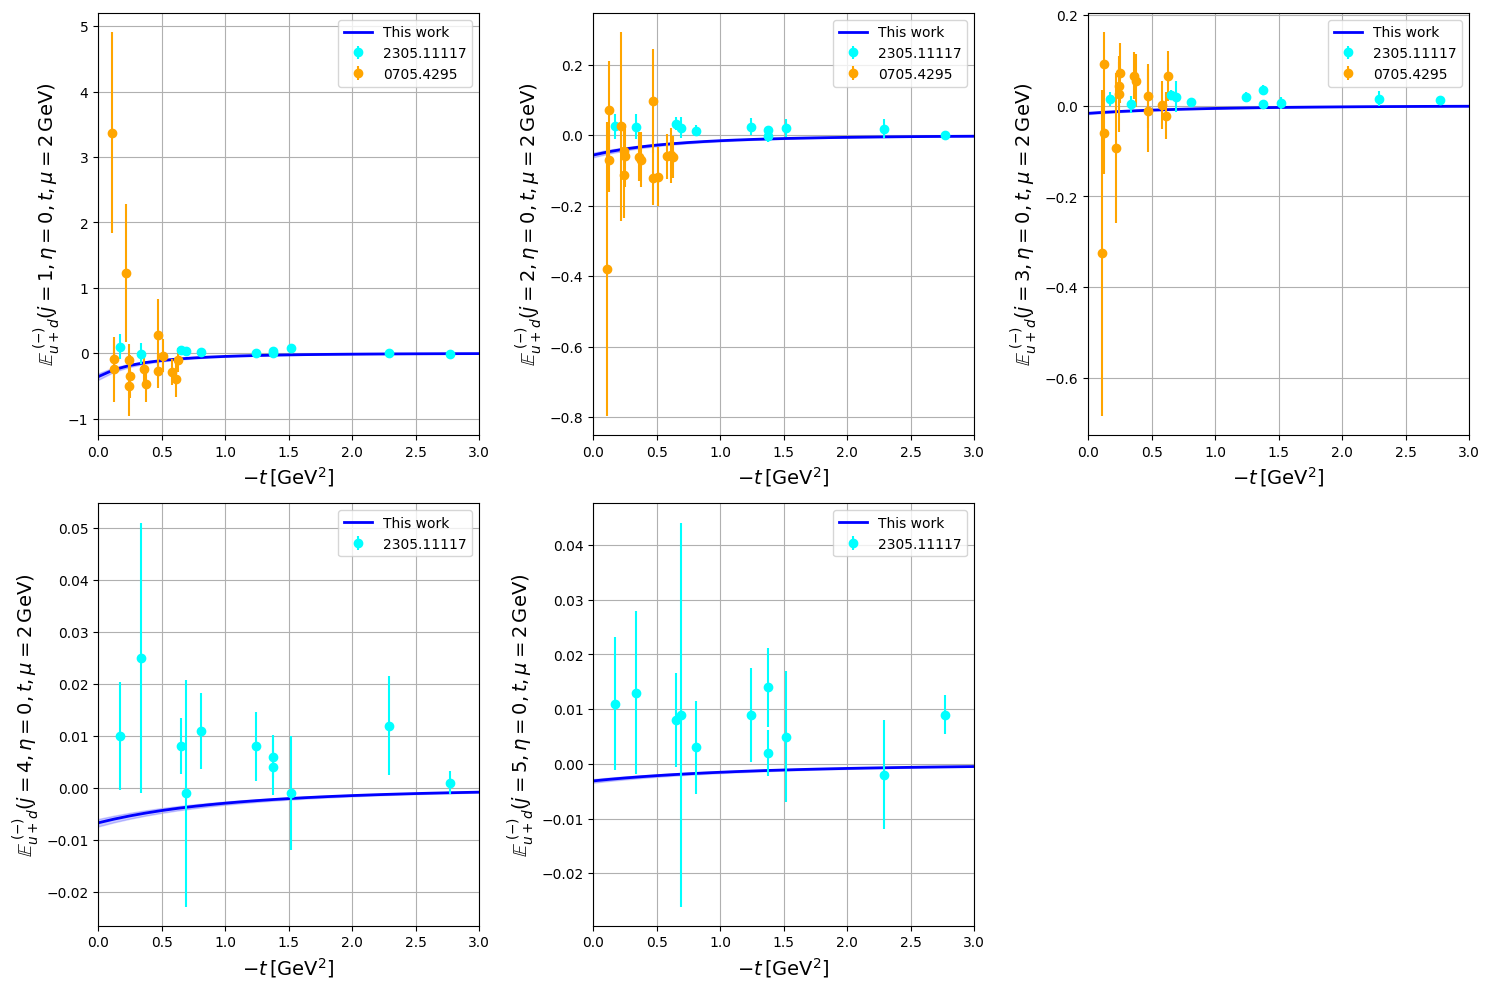

In [ ]:
# non_singlet_isoscalar
y_label = "$\\mathbb{{E}}_{{u+d}}^{{\,\,(-)}}$"
moment_type = "non_singlet_isoscalar"
moment_label = "B"

plot_moments_on_grid(0,y_label,3,1,"quark",moment_type, moment_label,"nlo",25)

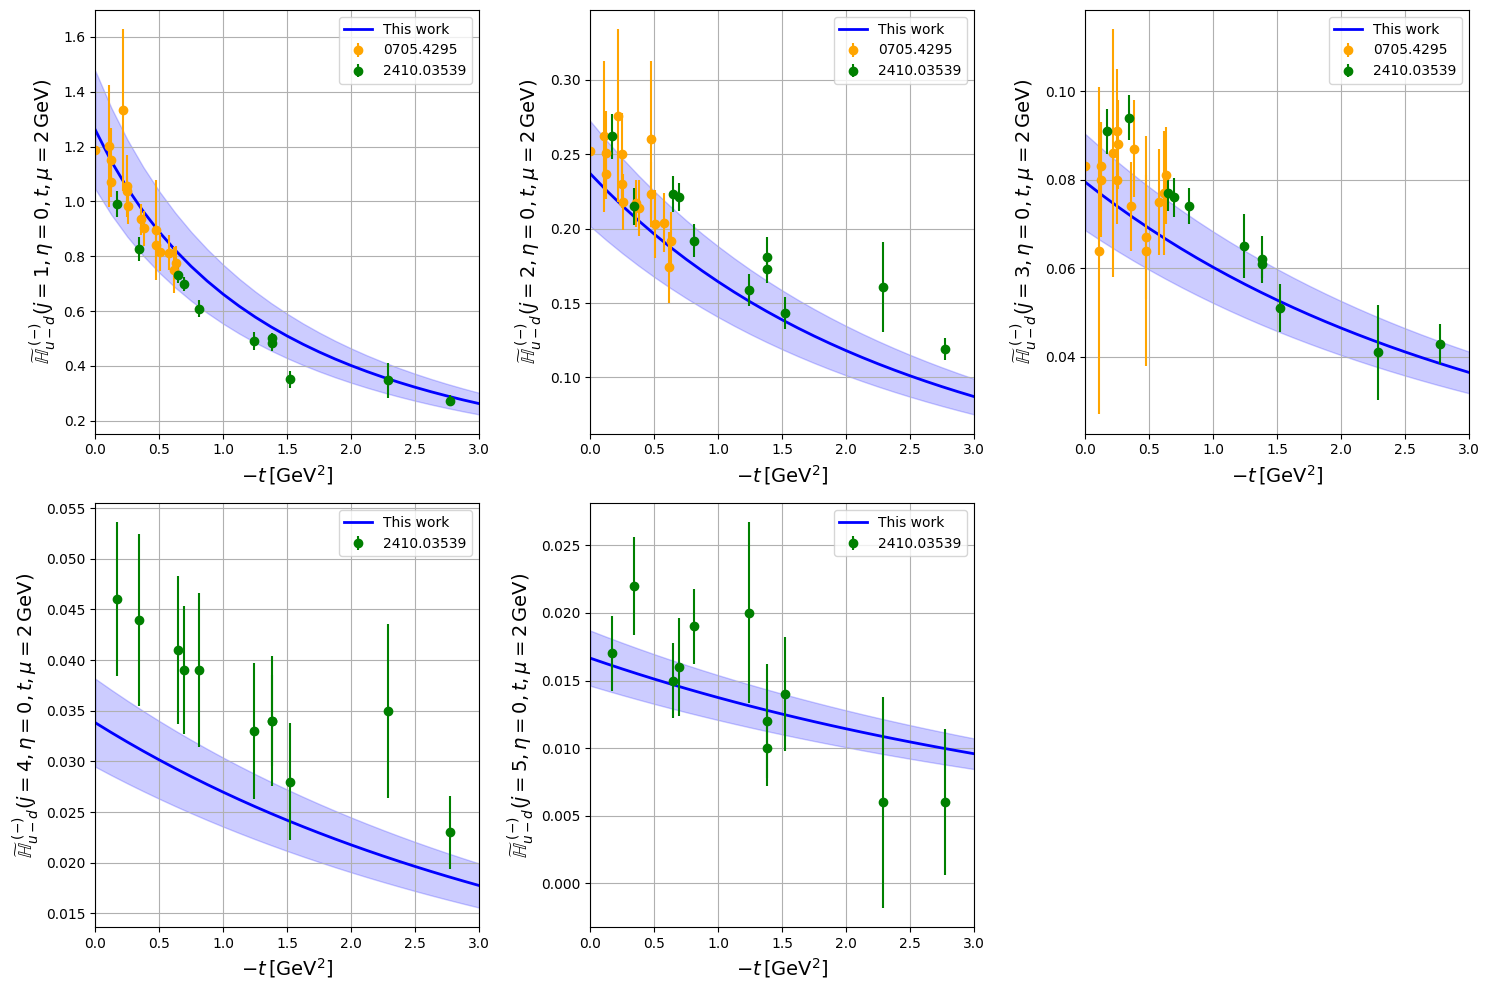

In [ ]:
#non_singlet_isovector axial
y_label = "$\\widetilde{\\mathbb{{H}}}_{{u-d}}^{{\,\,(-)}}$"
moment_type = "non_singlet_isovector"
moment_label = "Atilde"

plot_moments_on_grid(0,y_label,3,1,"quark",moment_type, moment_label,"nlo",25)

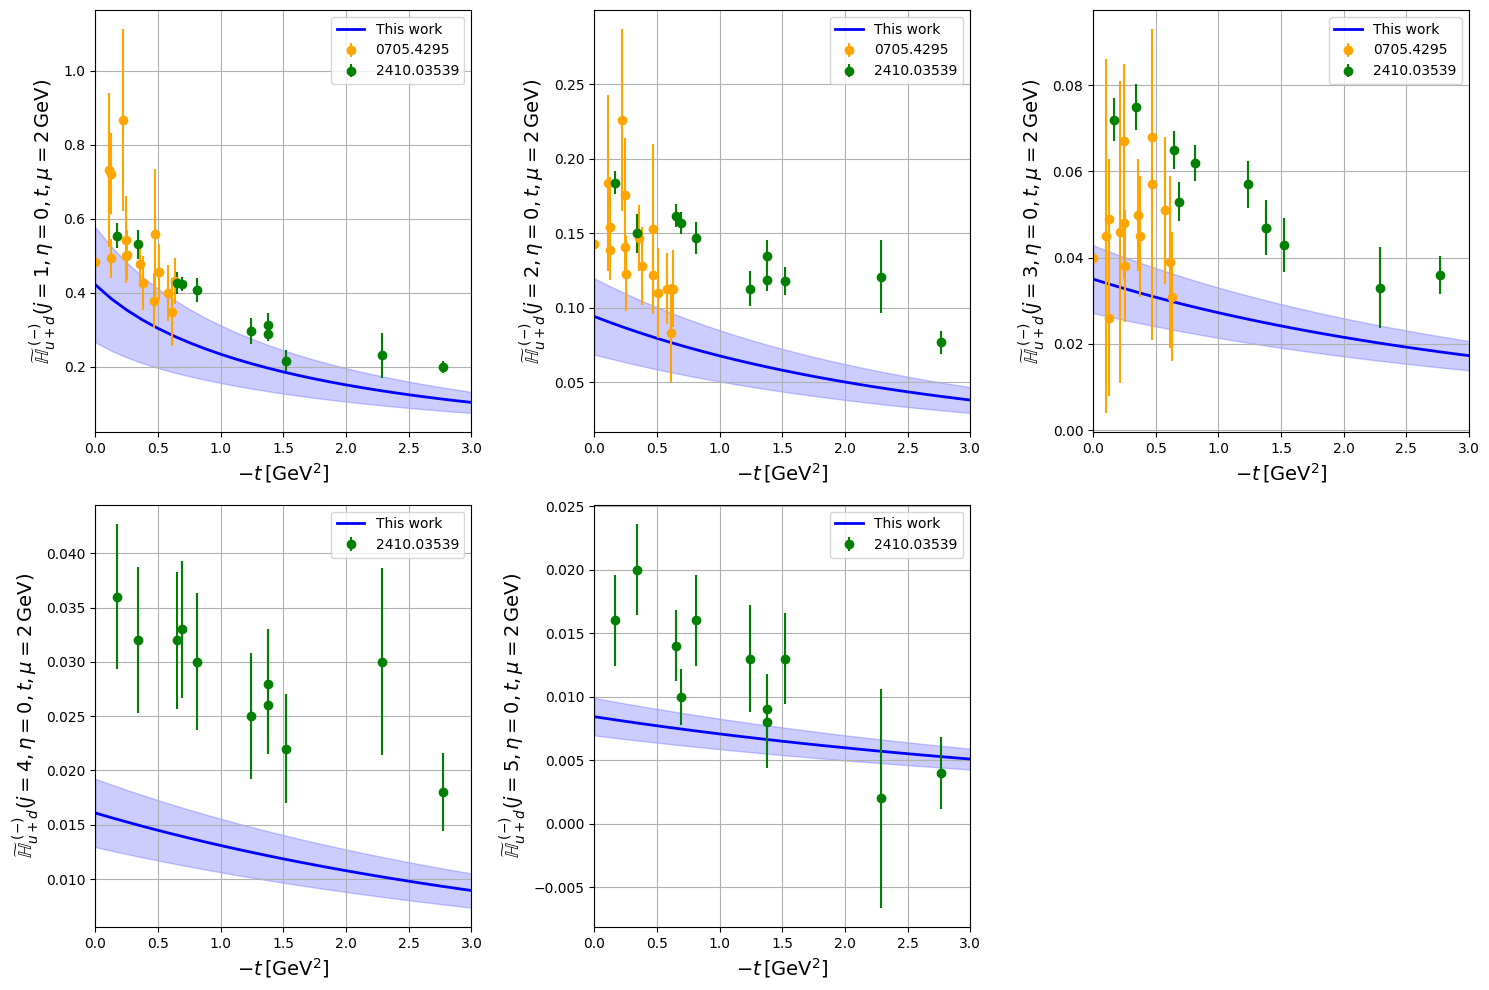

In [ ]:
#non_singlet_isoscalar axial
y_label = "$\\widetilde{\\mathbb{{H}}}_{{u+d}}^{{\,\,(-)}}$"
moment_type = "non_singlet_isoscalar"
moment_label = "Atilde"

plot_moments_on_grid(0,y_label,3,1,"quark",moment_type, moment_label,"nlo",25)

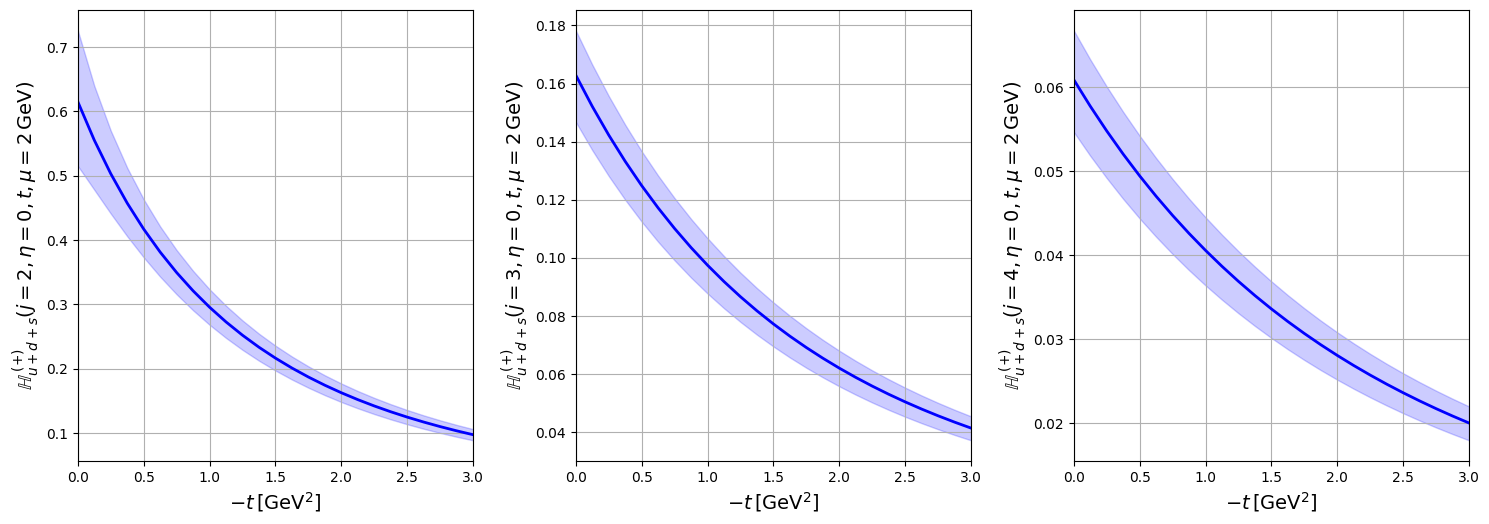

In [ ]:
# Sea Quark singlet
y_label = "$\\mathbb{{H}}_{{u+d+s}}^{{\,\,(+)}}$"
moment_type = "singlet"
moment_label = "A"

plot_moments_on_grid(0,y_label,3,1,"quark",moment_type, moment_label,"nlo",25)

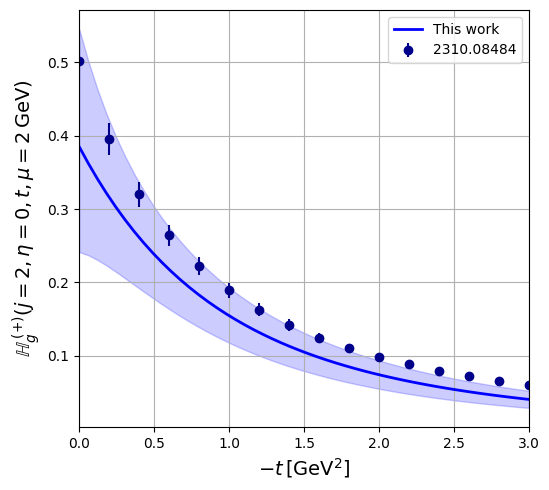

In [ ]:
# Note that the lattice data overshoots the PDF moment at t = 0
# Since we use MSTW PDF as input, we are compatible with most
# recent PDF anaylses.
y_label = "$\\mathbb{{H}}_{{g}}^{{\,\,(+)}}$"
particle = "gluon"
moment_type = "singlet"
moment_label = "A"
plot_moments_on_grid(0,y_label,3,1,particle,moment_type,moment_label,evolution_order="nlo",n_t=50)

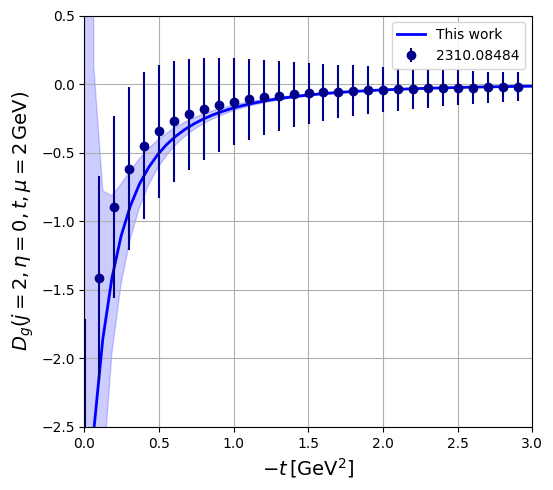

In [4]:
y_label = "$D_{{g}}$"
particle = "gluon"
moment_type = "singlet"
moment_label = "A"
plot_moments_on_grid(1,y_label,3,1,particle,moment_type,moment_label,D_term=True,y_0 = -2.5, y_1=.5,set_y_lim=True,evolution_order="nlo")

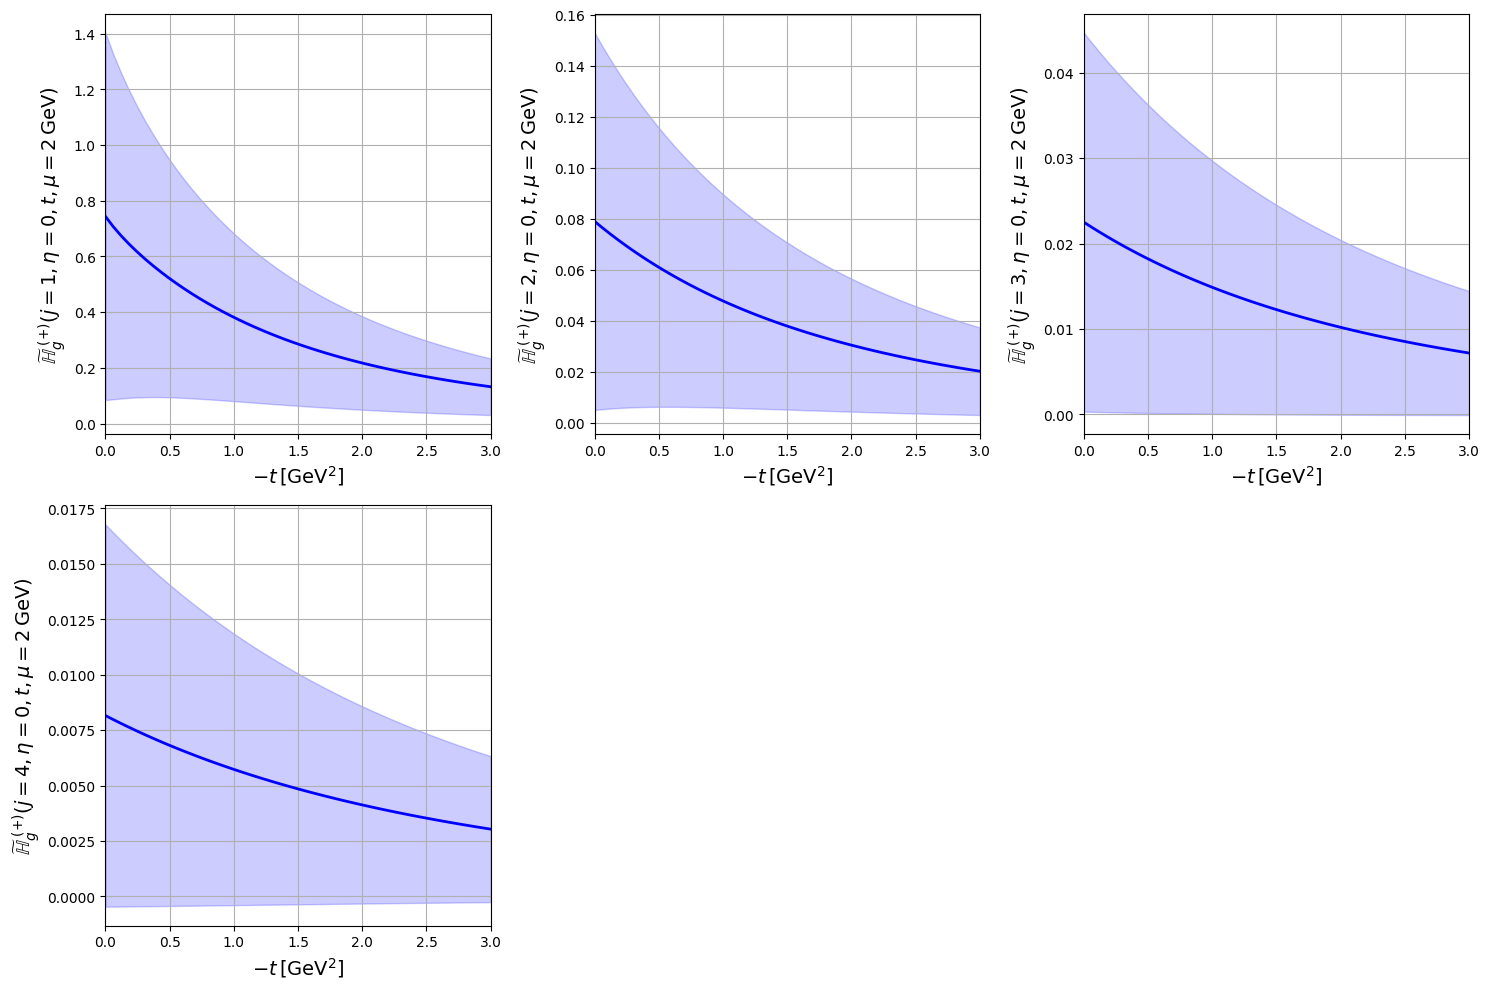

In [ ]:
# Gluon singlet axial
y_label = "$\\widetilde{\\mathbb{{H}}}_{{g}}^{{\,\,(+)}}$"
moment_type = "singlet"
moment_label = "Atilde"

plot_moments_on_grid(0,y_label,3,1,"gluon",moment_type, moment_label,evolution_order="nlo")

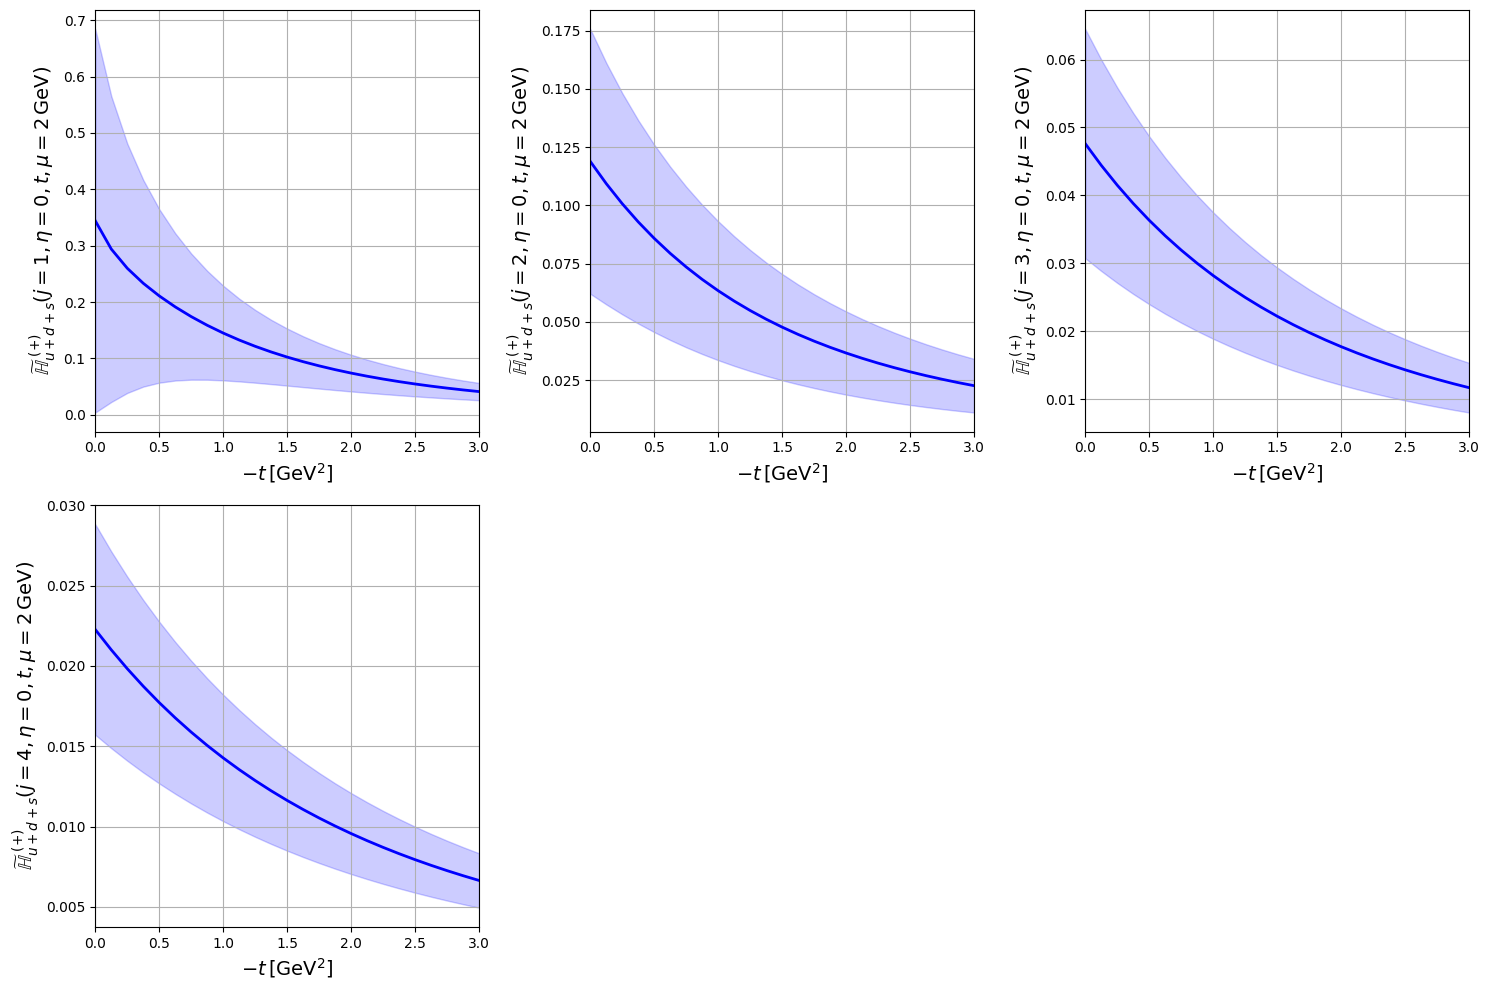

In [ ]:
# Sea Quark singlet
y_label = "$\\widetilde{\\mathbb{{H}}}_{{u+d+s}}^{{\,\,(+)}}$"
moment_type = "singlet"
moment_label = "Atilde"

plot_moments_on_grid(0,y_label,3,1,"quark",moment_type, moment_label,"nlo",25)

Plots of GPDs through Mellin-Barnes Integral

In [ ]:
from stringy_gpds import generate_moment_table
import stringy_gpds.config as cfg
from itertools import product

# To generate all moment tables as defined
# by the kinematics in config.py we can use

def generate_all_moment_tables():
    def update_param(filename, key, new_value):
        with open(filename, 'r') as file:
            lines = file.readlines()

        with open(filename, 'w') as file:
            for line in lines:
                if line.strip().startswith(f"{key} ="):
                    file.write(f"{key} = {repr(new_value)}\n")
                else:
                    file.write(line)
    cfg_path = cfg.Path(cfg.__file__)
    for eta, t, mu in zip(cfg.ETA_ARRAY, cfg.T_ARRAY, cfg.MU_ARRAY):
        for particle,moment_type, moment_label, evolution_order in product(cfg.PARTICLES,cfg.MOMENTS, cfg.LABELS, cfg.ORDERS):
            if particle == "gluon" and moment_type != "singlet":
                continue
            if moment_label == "B" and moment_type == "singlet":
                continue
            print(f"Working on {particle,moment_type,moment_label, evolution_order} at (eta,t,mu) = {eta,t,mu}...")
            generate_moment_table(eta,t,mu,solution=".",particle=particle,moment_type=moment_type,moment_label=moment_label,evolution_order=evolution_order,error_type="central",step=.1)
    # Switch to interpolation of evolved moments
    update_param(cfg_path,'INTERPOLATE_MOMENTS',True) 
    print("Done - Restart kernel to proceed with GPD computation")

generate_all_moment_tables()

Time for plot computation for parameters (eta,t) = ((0.0, -0.17)): 0.025458 seconds
Time for plot computation for parameters (eta,t) = ((0.0, -0.65)): 0.037657 seconds
Time for plot computation for parameters (eta,t) = ((0.0, -0.17)): 0.026034 seconds
Time for plot computation for parameters (eta,t) = ((0.0, -0.65)): 0.022914 seconds
Time for plot computation for parameters (eta,t) = ((0.0, -0.17)): 0.028769 seconds
Time for plot computation for parameters (eta,t) = ((0.0, -0.65)): 0.027225 seconds


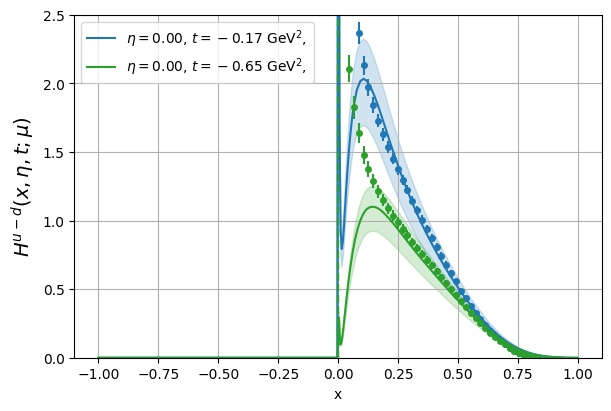

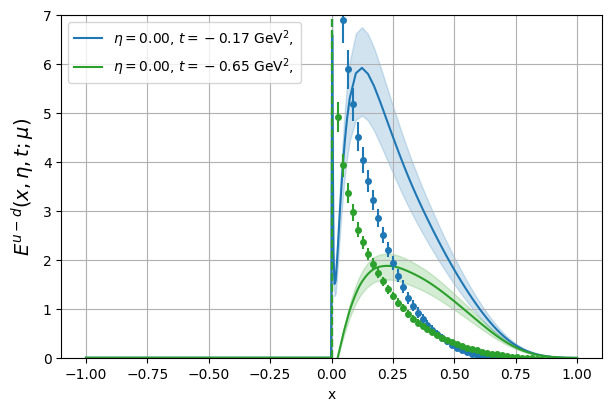

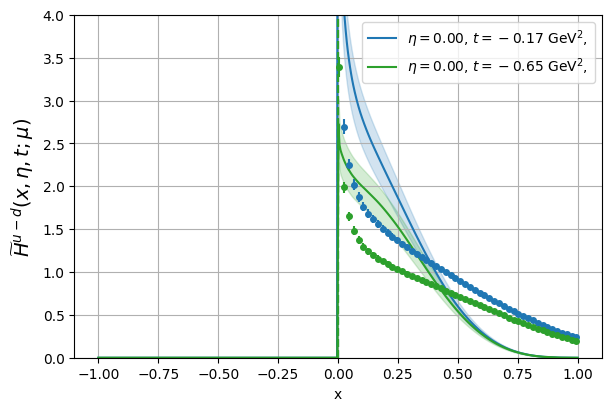

In [2]:
from stringy_gpds import plot_gpd_data

plot_gpd_data(particle="quark",gpd_type="non_singlet_isovector",gpd_label="H",evolution_order="nlo", y_0=0, y_1=2.5,plot_legend=True)
plot_gpd_data(particle="quark",gpd_type="non_singlet_isovector",gpd_label="E",evolution_order="nlo", y_0=0, y_1=7,plot_legend=True)
plot_gpd_data(particle="quark",gpd_type="non_singlet_isovector",gpd_label="Htilde",evolution_order="nlo", y_0=0, y_1=4,plot_legend=True)

Time for initial sampling for parameters (eta,t,mu) = ((0, -0.69, 2)): 1.909724 seconds


100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [00:10<00:00,  9.14it/s]


Time for plot computation for parameters (eta,t,mu) = ((0, -0.69, 2)): 32.261530 seconds
Saved data to /mnt/c/Users/flori/Documents/PostDoc/Data/stringy-gpds/GPDs/singlet_quark_GPD_Htilde_nlo_000_069_200.csv
Saved data to /mnt/c/Users/flori/Documents/PostDoc/Data/stringy-gpds/GPDs/singlet_quark_GPD_Htilde_nlo_000_069_200_plus.csv
Saved data to /mnt/c/Users/flori/Documents/PostDoc/Data/stringy-gpds/GPDs/singlet_quark_GPD_Htilde_nlo_000_069_200_minus.csv
Time for initial sampling for parameters (eta,t,mu) = ((0.33, -0.69, 2)): 3.612094 seconds


100%|█████████████████████████████████████████████████████████████████████████████████| 101/101 [00:34<00:00,  2.89it/s]


Time for plot computation for parameters (eta,t,mu) = ((0.33, -0.69, 2)): 92.399275 seconds
Saved data to /mnt/c/Users/flori/Documents/PostDoc/Data/stringy-gpds/GPDs/singlet_quark_GPD_Htilde_nlo_033_069_200.csv
Saved data to /mnt/c/Users/flori/Documents/PostDoc/Data/stringy-gpds/GPDs/singlet_quark_GPD_Htilde_nlo_033_069_200_plus.csv
Saved data to /mnt/c/Users/flori/Documents/PostDoc/Data/stringy-gpds/GPDs/singlet_quark_GPD_Htilde_nlo_033_069_200_minus.csv
Time for initial sampling for parameters (eta,t,mu) = ((0.1, -0.23, 2)): 5.436966 seconds


100%|█████████████████████████████████████████████████████████████████████████████████| 101/101 [00:30<00:00,  3.33it/s]


Time for plot computation for parameters (eta,t,mu) = ((0.1, -0.23, 2)): 78.108871 seconds
Saved data to /mnt/c/Users/flori/Documents/PostDoc/Data/stringy-gpds/GPDs/singlet_quark_GPD_Htilde_nlo_010_023_200.csv
Saved data to /mnt/c/Users/flori/Documents/PostDoc/Data/stringy-gpds/GPDs/singlet_quark_GPD_Htilde_nlo_010_023_200_plus.csv
Saved data to /mnt/c/Users/flori/Documents/PostDoc/Data/stringy-gpds/GPDs/singlet_quark_GPD_Htilde_nlo_010_023_200_minus.csv
File saved to /mnt/c/Users/flori/Documents/PostDoc/Plots/stringy-gpds/singlet_quark_GPD_Htilde.pdf


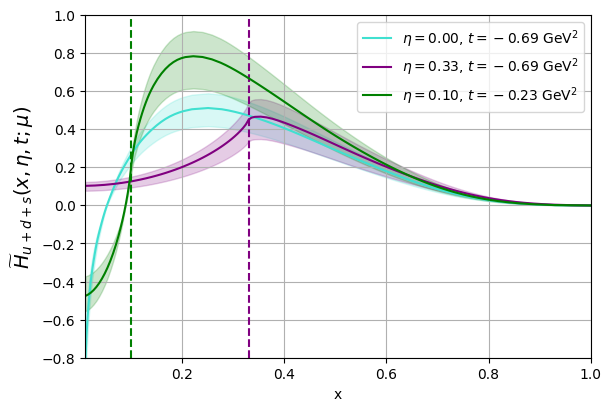

In [5]:
from stringy_gpds.core import plot_gpds
import stringy_gpds.config as cfg
eta_array = cfg.ETA_ARRAY
t_array = cfg.T_ARRAY
mu_array = cfg.MU_ARRAY
colors = ["turquoise","purple","green"]
plot_gpds(eta_array,t_array,mu_array,colors,particle="quark",gpd_type="singlet",gpd_label="Htilde",evolution_order="nlo",error_bars=True, read_from_file= False,write_to_file=True, y_0=-.8, y_1=1,plot_legend=True)

In [7]:
from stringy_gpds import plot_gpds
import stringy_gpds.config as cfg
eta_array = cfg.ETA_ARRAY
t_array = cfg.T_ARRAY
mu_array = cfg.MU_ARRAY
colors = ["turquoise","purple","green"]
plot_gpds(eta_array,t_array,mu_array,colors,particle="gluon",gpd_type="singlet",gpd_label="Htilde",evolution_order="nlo",error_bars=True, read_from_file= True,write_to_file=False, y_0=0, y_1=.3,plot_legend=True)

Time for plot computation for parameters (eta,t) = ((0.0, -0.69)): 0.029992 seconds
Time for plot computation for parameters (eta,t) = ((0.33, -0.69)): 0.016794 seconds
Time for plot computation for parameters (eta,t) = ((0.0, -0.39)): 0.024066 seconds
Time for plot computation for parameters (eta,t) = ((0.1, -0.23)): 0.015989 seconds


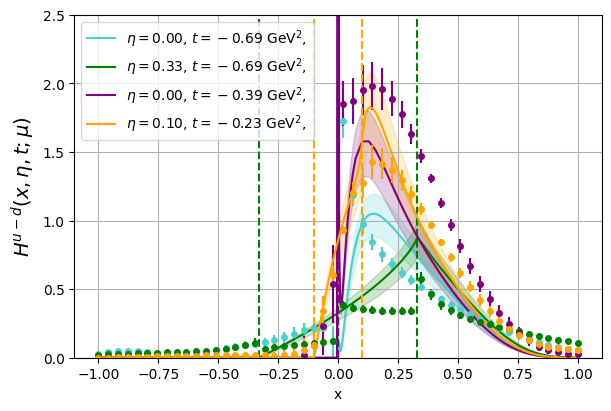

In [2]:
from stringy_gpds import plot_gpd_data

plot_gpd_data(particle="quark",gpd_type="non_singlet_isovector",gpd_label="H",evolution_order="nlo", y_0=0, y_1=2.5,plot_legend=True)

In [17]:
# The necessary dipole fits used for the impact
# parameter space plots in the publication
# are generated by
from stringy_gpds.fit import dipole_fit_moment
from itertools import product
# Optionally we can display the plot
plot_fit = False
eta_vals = [0,.1,1/3]

for eta, error_type, evolution_order in  product(eta_vals,["central","plus","minus"],["lo","nlo"]):
    dipole_fit_moment(1,eta,2,particle="quark",moment_type="non_singlet_isovector",moment_label="B",evolution_order=evolution_order,error_type=error_type,plot_fit=plot_fit)
    dipole_fit_moment(1,eta,2,particle="quark",moment_type="non_singlet_isoscalar",moment_label="B",evolution_order=evolution_order,error_type=error_type,plot_fit=plot_fit)
    dipole_fit_moment(2,eta,2,particle="quark",moment_type="non_singlet_isovector",moment_label="B",evolution_order=evolution_order,error_type=error_type,plot_fit=plot_fit)
    dipole_fit_moment(2,eta,2,particle="quark",moment_type="non_singlet_isoscalar",moment_label="B",evolution_order=evolution_order,error_type=error_type,plot_fit=plot_fit)
    dipole_fit_moment(3,eta,2,particle="quark",moment_type="non_singlet_isovector",moment_label="B",evolution_order=evolution_order,error_type=error_type,plot_fit=plot_fit)
    dipole_fit_moment(3,eta,2,particle="quark",moment_type="non_singlet_isoscalar",moment_label="B",evolution_order=evolution_order,error_type=error_type,plot_fit=plot_fit)
    dipole_fit_moment(4,eta,2,particle="quark",moment_type="non_singlet_isovector",moment_label="B",evolution_order=evolution_order,error_type=error_type,plot_fit=plot_fit)
    dipole_fit_moment(4,eta,2,particle="quark",moment_type="non_singlet_isoscalar",moment_label="B",evolution_order=evolution_order,error_type=error_type,plot_fit=plot_fit)
    dipole_fit_moment(1,eta,2,particle="quark",moment_type="non_singlet_isovector",moment_label="A",evolution_order=evolution_order,error_type=error_type,plot_fit=plot_fit)
    dipole_fit_moment(1,eta,2,particle="quark",moment_type="non_singlet_isoscalar",moment_label="A",evolution_order=evolution_order,error_type=error_type,plot_fit=plot_fit)
    dipole_fit_moment(2,eta,2,particle="quark",moment_type="non_singlet_isovector",moment_label="A",evolution_order=evolution_order,error_type=error_type,plot_fit=plot_fit)
    dipole_fit_moment(2,eta,2,particle="quark",moment_type="non_singlet_isoscalar",moment_label="A",evolution_order=evolution_order,error_type=error_type,plot_fit=plot_fit)
    dipole_fit_moment(3,eta,2,particle="quark",moment_type="non_singlet_isovector",moment_label="A",evolution_order=evolution_order,error_type=error_type,plot_fit=plot_fit)
    dipole_fit_moment(3,eta,2,particle="quark",moment_type="non_singlet_isoscalar",moment_label="A",evolution_order=evolution_order,error_type=error_type,plot_fit=plot_fit)
    dipole_fit_moment(4,eta,2,particle="quark",moment_type="non_singlet_isovector",moment_label="A",evolution_order=evolution_order,error_type=error_type,plot_fit=plot_fit)
    dipole_fit_moment(4,eta,2,particle="quark",moment_type="non_singlet_isoscalar",moment_label="A",evolution_order=evolution_order,error_type=error_type,plot_fit=plot_fit)
    dipole_fit_moment(1,eta,2,particle="quark",moment_type="non_singlet_isovector",moment_label="Atilde",evolution_order=evolution_order,error_type=error_type,plot_fit=plot_fit)
    dipole_fit_moment(1,eta,2,particle="quark",moment_type="non_singlet_isoscalar",moment_label="Atilde",evolution_order=evolution_order,error_type=error_type,plot_fit=plot_fit)
    dipole_fit_moment(2,eta,2,particle="quark",moment_type="non_singlet_isovector",moment_label="Atilde",evolution_order=evolution_order,error_type=error_type,plot_fit=plot_fit)
    dipole_fit_moment(2,eta,2,particle="quark",moment_type="non_singlet_isoscalar",moment_label="Atilde",evolution_order=evolution_order,error_type=error_type,plot_fit=plot_fit)
    dipole_fit_moment(1,eta,2,particle="quark",moment_type="singlet",moment_label="Atilde",evolution_order=evolution_order,error_type=error_type,plot_fit=plot_fit)
    dipole_fit_moment(1,eta,2,particle="gluon",moment_type="singlet",moment_label="Atilde",evolution_order=evolution_order,error_type=error_type,plot_fit=plot_fit)
    dipole_fit_moment(2,eta,2,particle="quark",moment_type="singlet",moment_label="A",evolution_order=evolution_order,error_type=error_type,plot_fit=plot_fit)
    dipole_fit_moment(2,eta,2,particle="gluon",moment_type="singlet",moment_label="A",evolution_order=evolution_order,error_type=error_type,plot_fit=plot_fit)
    dipole_fit_moment(2,eta,2,particle="quark",moment_type="singlet",moment_label="Atilde",evolution_order=evolution_order,error_type=error_type,plot_fit=plot_fit)
    dipole_fit_moment(2,eta,2,particle="gluon",moment_type="singlet",moment_label="Atilde",evolution_order=evolution_order,error_type=error_type,plot_fit=plot_fit)
    dipole_fit_moment(2,eta,2,particle="quark",moment_type="singlet",moment_label="B",evolution_order=evolution_order,error_type=error_type,plot_fit=plot_fit)
    dipole_fit_moment(2,eta,2,particle="gluon",moment_type="singlet",moment_label="B",evolution_order=evolution_order,error_type=error_type,plot_fit=plot_fit)

(n, eta, mu, particle, moment_type, moment_label, evolution_order,error_type) = (1, 0, 2, 'quark', 'singlet', 'Atilde', 'lo', 'minus').
Positive values:15, Negative values: 1
(n, eta, mu, particle, moment_type, moment_label, evolution_order,error_type) = (1, 0.1, 2, 'quark', 'singlet', 'Atilde', 'lo', 'minus').
Positive values:15, Negative values: 1
(n, eta, mu, particle, moment_type, moment_label, evolution_order,error_type) = (2, 0.1, 2, 'quark', 'singlet', 'A', 'lo', 'minus').
Positive values:15, Negative values: 1
(n, eta, mu, particle, moment_type, moment_label, evolution_order,error_type) = (2, 0.1, 2, 'gluon', 'singlet', 'A', 'lo', 'minus').
Positive values:15, Negative values: 1
(n, eta, mu, particle, moment_type, moment_label, evolution_order,error_type) = (2, 0.1, 2, 'quark', 'singlet', 'B', 'lo', 'minus').
Positive values:15, Negative values: 1
(n, eta, mu, particle, moment_type, moment_label, evolution_order,error_type) = (2, 0.1, 2, 'gluon', 'singlet', 'B', 'lo', 'minus').

In [5]:
from stringy_gpds.core import orbital_angular_momentum
orbital_angular_momentum(0,0,2,particle="gluon",moment_type="singlet")

(-0.17936888136148388,
 np.float64(0.3172689191300203),
 np.float64(0.31524228017453354))

In [8]:
from stringy_gpds.core import orbital_angular_momentum, quark_gluon_helicity
# orbital_angular_momentum(0,0,2,particle="quark",moment_type="singlet")
quark_gluon_helicity(0,0,2,particle="quark",moment_type="singlet")

(0.17207674026303774, 0.12019159711556812, 0.12019159711556812)

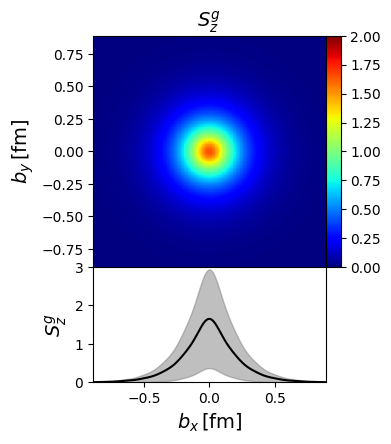

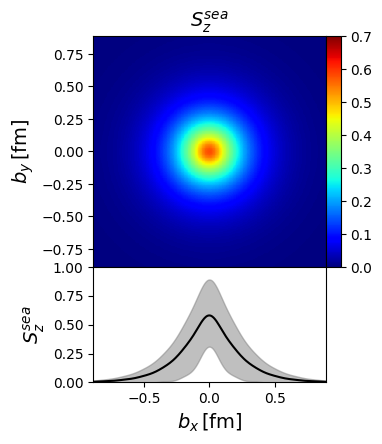

In [4]:
from stringy_gpds.plot import plot_fourier_transform_singlet_helicity
plot_fourier_transform_singlet_helicity(0,2,particle="gluon",vmin=0,vmax=2,ymin=0,ymax=3,read_from_file=True,write_to_file=False)
plot_fourier_transform_singlet_helicity(0,2,particle="quark",vmin=0,vmax=.7,ymin=0,ymax=1,read_from_file=True,write_to_file=False)

In [24]:
# The necessary dipole fits used for the impact
# parameter space plots in the publication
# are generated by
from stringy_gpds.fit import dipole_fit_moment
from itertools import product
import numpy as np
# Optionally we can display the plot
plot_fit = False
eta_vals = [0,.1,.33,.5,.7,.8]
for eta, error_type, evolution_order in  product(eta_vals,["central","plus","minus"],["nlo"]):
    dipole_fit_moment(1,eta,2,particle="quark",moment_type="singlet",moment_label="Atilde",evolution_order=evolution_order,error_type=error_type,plot_fit=plot_fit)
    dipole_fit_moment(1,eta,2,particle="gluon",moment_type="singlet",moment_label="Atilde",evolution_order=evolution_order,error_type=error_type,plot_fit=plot_fit)
    dipole_fit_moment(2,eta,2,particle="quark",moment_type="singlet",moment_label="A",evolution_order=evolution_order,error_type=error_type,plot_fit=plot_fit)
    dipole_fit_moment(2,eta,2,particle="gluon",moment_type="singlet",moment_label="A",evolution_order=evolution_order,error_type=error_type,plot_fit=plot_fit)
    dipole_fit_moment(2,eta,2,particle="quark",moment_type="singlet",moment_label="Atilde",evolution_order=evolution_order,error_type=error_type,plot_fit=plot_fit)
    dipole_fit_moment(2,eta,2,particle="gluon",moment_type="singlet",moment_label="Atilde",evolution_order=evolution_order,error_type=error_type,plot_fit=plot_fit)
    dipole_fit_moment(2,eta,2,particle="quark",moment_type="singlet",moment_label="B",evolution_order=evolution_order,error_type=error_type,plot_fit=plot_fit)
    dipole_fit_moment(2,eta,2,particle="gluon",moment_type="singlet",moment_label="B",evolution_order=evolution_order,error_type=error_type,plot_fit=plot_fit)

(n, eta, mu, particle, moment_type, moment_label, evolution_order,error_type) = (2, 0.1, 2, 'quark', 'singlet', 'A', 'nlo', 'minus').
Positive values:15, Negative values: 1
(n, eta, mu, particle, moment_type, moment_label, evolution_order,error_type) = (2, 0.1, 2, 'gluon', 'singlet', 'A', 'nlo', 'minus').
Positive values:15, Negative values: 1
(n, eta, mu, particle, moment_type, moment_label, evolution_order,error_type) = (2, 0.1, 2, 'quark', 'singlet', 'Atilde', 'nlo', 'minus').
Positive values:15, Negative values: 1
(n, eta, mu, particle, moment_type, moment_label, evolution_order,error_type) = (2, 0.1, 2, 'gluon', 'singlet', 'Atilde', 'nlo', 'minus').
Positive values:15, Negative values: 1
(n, eta, mu, particle, moment_type, moment_label, evolution_order,error_type) = (2, 0.1, 2, 'quark', 'singlet', 'B', 'nlo', 'minus').
Positive values:15, Negative values: 1
(n, eta, mu, particle, moment_type, moment_label, evolution_order,error_type) = (2, 0.1, 2, 'gluon', 'singlet', 'B', 'nlo', '

100%|█████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 72.69it/s]


quark moment 0.6239300921113413
gluon moment 0.3894027932015477


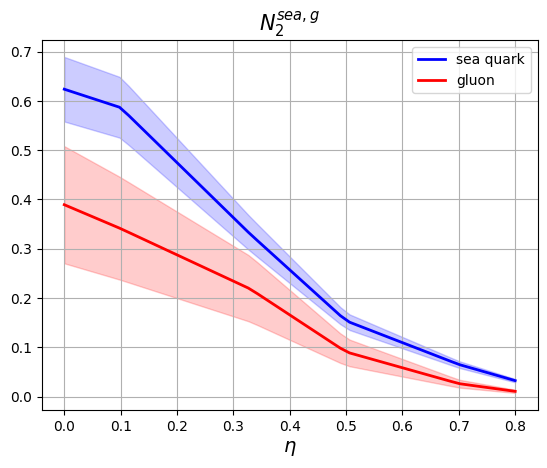

quark helicity 0.1738050721112666
gluon helicity 0.3786114743177062


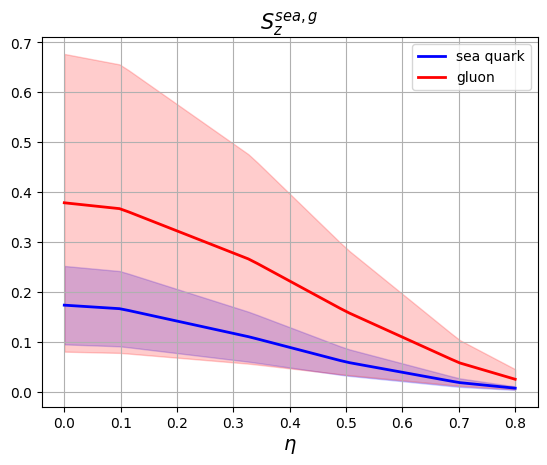

quark oam 0.13815997394440438
gluon oam -0.18391007771693216


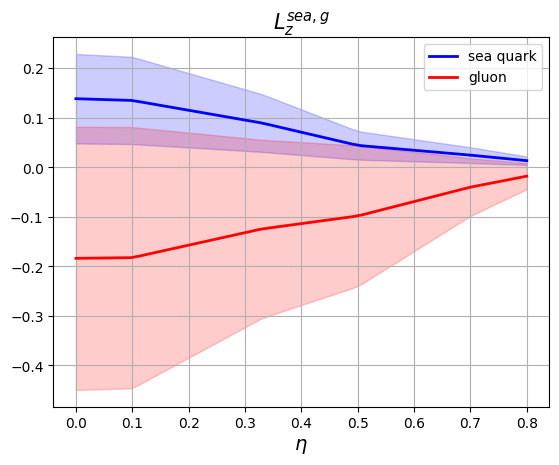

quark total_spin 0.311965046055671
gluon total_spin 0.19470139660077404


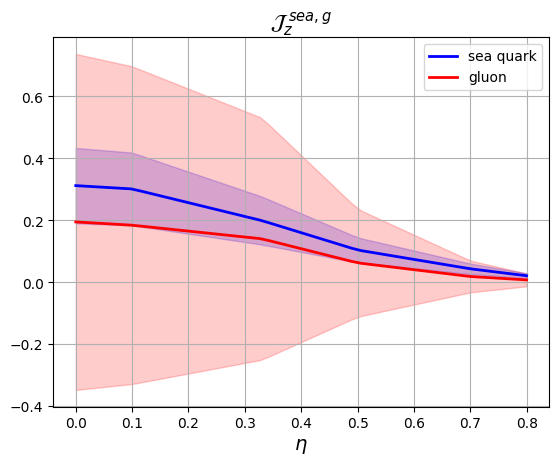

In [3]:
from stringy_gpds.core import fourier_transform_helicity, fourier_transform_orbital_angular_momentum, fourier_transform_moment
from scipy.integrate import fixed_quad
import numpy as np
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
import stringy_gpds.config as cfg
import stringy_gpds.helpers as hp
from tqdm import tqdm
from scipy.interpolate import interp1d
def plot_moments_over_rapidity(mu, evolution_order="nlo", Delta_max=10, b_max=10, dipole_form=True, interpolation=True):
    """
    Compute Fourier transformed moments using trapezoidal rule.

    Parameters
    ----------
    mu : float
        Resolution scale.
    evolution_order : str, optional
        "lo", "nlo",... . Default is "nlo"
    Delta_max : float, optional
        Maximal momentum transfer to cut off integration
    b_ax : float, optional
        Maximum impact parameter to cut off integration
    dipole_form : bool, optional
        Use dipole fit for faster integration.
    interpolation : bool, optional
        Interpolate results

    Returns
    -------
    None

    Notes
    -----
    This function creates a plot of the second singlet moment, 
    helicity, orbital angular momentum and total spin for 
    both quark and gluon singlet contributions over eta.
    The values for skewness at which data points are generated
    are [0,.1,.33,.5,.7,.8].
    
    The plot is saved under
    cfg.PLOT_PATH / f"..._rapidity_mu{mu}GeV.pdf" where 
    PLOT_PATH is defined in config.py
    """
    eta_vals = [0, .1, .33, .5, .7, .8]
    quantities = {
        "moment": {"color": "mediumvioletred", "title": r"$N_2^{sea,g}$", "filename": f"norm_rapidity_mu{mu}GeV.pdf"},
        "helicity": {"color": "dodgerblue", "title": r"$S_z^{sea,g}$", "filename": f"helicity_rapidity_mu{mu}GeV.pdf"},
        "oam": {"color": "forestgreen", "title": r"$L_z^{sea,g}$", "filename": f"oam_rapidity_mu{mu}GeV.pdf"},
        "total_spin": {"color": "orange", "title": r"$\mathcal{J}_z^{\ sea,g}$", "filename": f"total_spin_rapidity_mu{mu}GeV.pdf"},
    }

    label_map = {
        "quark" : "sea quark",
        "gluon" : "gluon"
    }

    results_by_particle = {}

    for particle in ["quark", "gluon"]:
        def compute_results(eta, error_type):
            @hp.mpmath_vectorize
            def ft_moment(b_perp):
                ft = fourier_transform_moment(2, eta, mu, b_vec=(b_perp, 0), particle=particle,
                                              moment_type="singlet", moment_label="A", evolution_order=evolution_order,
                                              Delta_max=Delta_max, error_type=error_type, dipole_form=dipole_form)
                return b_perp * ft

            @hp.mpmath_vectorize
            def ft_helicity(b_perp):
                ft = fourier_transform_helicity(eta=eta, mu=mu, b_vec=(b_perp, 0), particle=particle,
                                                moment_type="singlet", evolution_order=evolution_order,
                                                Delta_max=Delta_max, error_type=error_type, dipole_form=dipole_form)
                return b_perp * ft

            @hp.mpmath_vectorize
            def ft_oam(b_perp):
                ft = fourier_transform_orbital_angular_momentum(eta=eta, mu=mu, b_vec=(b_perp, 0), particle=particle,
                                                                moment_type="singlet", evolution_order=evolution_order,
                                                                Delta_max=Delta_max, error_type=error_type, dipole_form=dipole_form)
                return b_perp * ft

            mom, _ = fixed_quad(ft_moment, 0, b_max, n=100)
            helicity, _ = fixed_quad(ft_helicity, 0, b_max, n=100)
            oam, _ = fixed_quad(ft_oam, 0, b_max, n=100)

            return 2 * np.pi * mom, 2 * np.pi * helicity, 2 * np.pi * oam

        with hp.tqdm_joblib(tqdm(total=len(eta_vals))) as progress_bar:
            res_c = Parallel(n_jobs=-1)(delayed(compute_results)(eta, "central") for eta in eta_vals)
        with hp.tqdm_joblib(tqdm(total=len(eta_vals))) as progress_bar:
            res_p = Parallel(n_jobs=-1)(delayed(compute_results)(eta, "plus") for eta in eta_vals)
        with hp.tqdm_joblib(tqdm(total=len(eta_vals))) as progress_bar:
            res_m = Parallel(n_jobs=-1)(delayed(compute_results)(eta, "minus") for eta in eta_vals)

        mom_c, helicity_c, oam_c = map(np.array, zip(*res_c))
        mom_p, helicity_p, oam_p = map(np.array, zip(*res_p))
        mom_m, helicity_m, oam_m = map(np.array, zip(*res_m))

        total_c = helicity_c + oam_c
        total_p = total_c + np.sqrt((helicity_p - helicity_c)**2 + (oam_p - oam_c)**2)
        total_m = total_c - np.sqrt((helicity_m - helicity_c)**2 + (oam_m - oam_c)**2)

        results_by_particle[particle] = {
            "moment": (mom_c, np.abs(mom_c - mom_m)),
            "helicity": (helicity_c, np.abs(helicity_c - helicity_m)),
            "oam": (oam_c, np.abs(oam_c - oam_m)),
            "total_spin": (total_c, np.abs(total_c - total_m)),
            "marker": "o" if particle == "gluon" else "^",
            "color": "red" if particle == "gluon" else "blue"
        }
        # Relative error estimate by averaging since dipole fits are unreliable
        if dipole_form:
            for key, val_err in zip(
                ["moment", "helicity", "oam", "total_spin"],
                [(mom_c, mom_m),
                (helicity_c, helicity_m),
                (oam_c, oam_m),
                (total_c, total_m)]
            ):
                val, val_m = val_err
                # Avoid divide-by-zero
                safe_val = np.where(val == 0, 1e-10, val)
                rel_err = np.abs((val - val_m) / safe_val)
                avg_rel_err = np.mean(rel_err)
                stable_err = avg_rel_err * np.abs(val)

                results_by_particle[particle][key] = (val, stable_err)

    if interpolation:
        eta_int_vals = np.linspace(min(eta_vals), max(eta_vals), 50)
        for particle in results_by_particle:
            for key in ["moment", "helicity", "oam", "total_spin"]:
                vals, err = results_by_particle[particle][key]

                # Interpolate central value
                f_vals = interp1d(eta_vals, vals, kind="linear")
                new_vals = f_vals(eta_int_vals)

                # Interpolate error
                f_err = interp1d(eta_vals, err, kind="linear")
                new_err = f_err(eta_int_vals)

                # Replace with interpolated
                results_by_particle[particle][key] = (new_vals, new_err)
        eta_vals = eta_int_vals

    # Plot each quantity with both quark and gluon
    for key, props in quantities.items():
        fig, ax = plt.subplots()
        for particle, data in results_by_particle.items():
            vals, err = data[key]
            label = label_map[particle]
            ax.plot(eta_vals, vals, color=data["color"], linewidth=2,label=label)
            # Add markers when not interpolated
            if not interpolation:
                ax.plot(eta_vals, vals, color=data["color"], marker=data["marker"], linestyle="none", markersize=6)
            ax.fill_between(eta_vals, vals - err, vals + err, color=data["color"], alpha=0.2)
            print(particle,key,vals[0])

        ax.set_title(props["title"], fontsize=15)
        ax.set_xlabel(r"$\eta$", fontsize=14)
        ax.grid(True, which="both")
        fig.subplots_adjust(wspace=0, hspace=0)
        plt.legend()
        out_path = cfg.PLOT_PATH / props["filename"]
        fig.savefig(out_path, format="pdf", bbox_inches="tight", dpi=600)
        plt.show()
        plt.close()

plot_moments_over_rapidity(2)

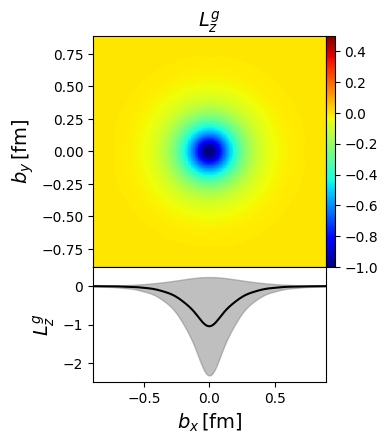

In [ ]:
from stringy_gpds.plot import plot_fourier_transform_singlet_orbital_angular_momentum
plot_fourier_transform_singlet_orbital_angular_momentum(0,2,particle="gluon",vmin=-1.5,vmax=.5,ymin=-2.5,ymax=.5,read_from_file=True,write_to_file=False)

Saved data to /home/hechenvanmountain/stringy-gpds/data/ImpactParameterMoments/imp_param_oam_singlet_quark_000_000_200.csv
Saved data to /home/hechenvanmountain/stringy-gpds/data/ImpactParameterMoments/imp_param_oam_singlet_quark_000_000_200_plus.csv
Saved data to /home/hechenvanmountain/stringy-gpds/data/ImpactParameterMoments/imp_param_oam_singlet_quark_000_000_200_minus.csv


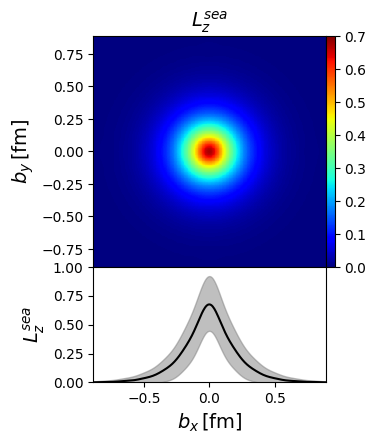

In [2]:
plot_fourier_transform_singlet_orbital_angular_momentum(0,2,particle="quark",vmin=0,vmax=0.7,ymin=0,ymax=1,read_from_file=False,write_to_file=True)

Saved data to /home/hechenvanmountain/stringy-gpds/data/ImpactParameterMoments/imp_param_transv_pol_moment_j_1_non_singlet_isovector_010_000_200.csv
Saved data to /home/hechenvanmountain/stringy-gpds/data/ImpactParameterMoments/imp_param_transv_pol_moment_j_1_non_singlet_isoscalar_010_000_200.csv
Saved data to /home/hechenvanmountain/stringy-gpds/data/ImpactParameterMoments/imp_param_transv_pol_moment_j_1_u_010_000_200.csv
Saved data to /home/hechenvanmountain/stringy-gpds/data/ImpactParameterMoments/imp_param_transv_pol_moment_j_1_d_010_000_200.csv


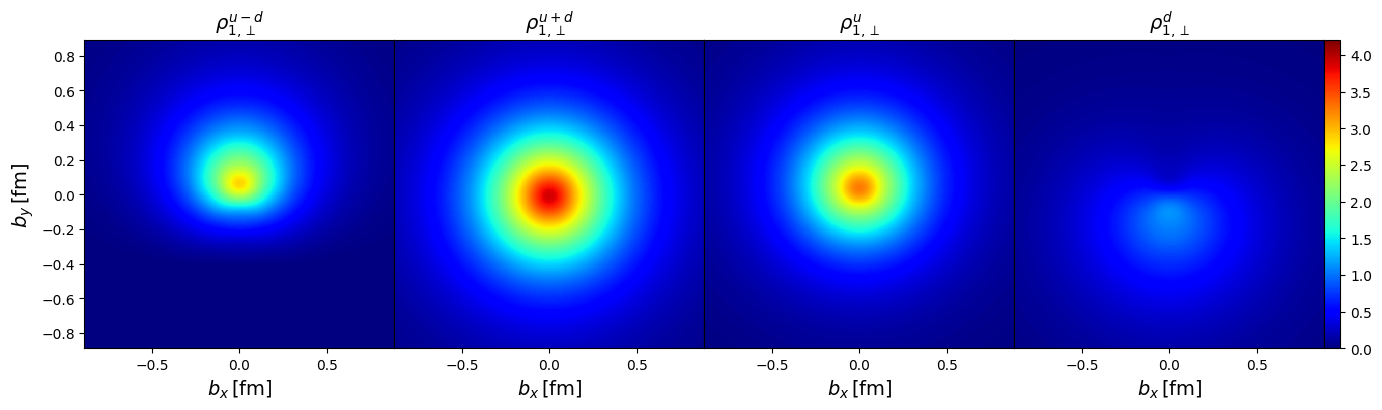

Saved data to /home/hechenvanmountain/stringy-gpds/data/ImpactParameterMoments/imp_param_transv_pol_moment_j_2_non_singlet_isovector_010_000_200.csv
Saved data to /home/hechenvanmountain/stringy-gpds/data/ImpactParameterMoments/imp_param_transv_pol_moment_j_2_non_singlet_isoscalar_010_000_200.csv
Saved data to /home/hechenvanmountain/stringy-gpds/data/ImpactParameterMoments/imp_param_transv_pol_moment_j_2_u_010_000_200.csv
Saved data to /home/hechenvanmountain/stringy-gpds/data/ImpactParameterMoments/imp_param_transv_pol_moment_j_2_d_010_000_200.csv


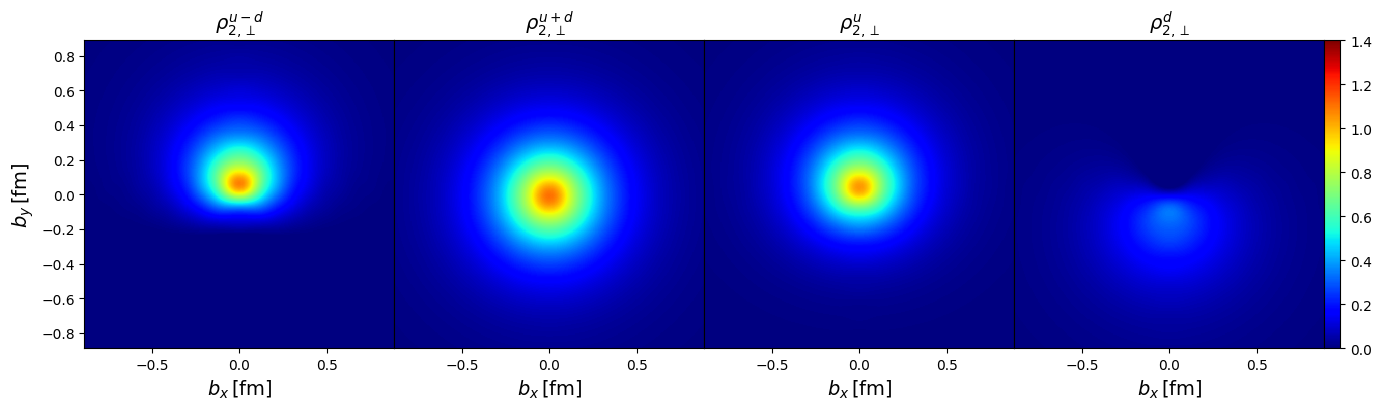

Saved data to /home/hechenvanmountain/stringy-gpds/data/ImpactParameterMoments/imp_param_transv_pol_moment_j_3_non_singlet_isovector_010_000_200.csv
Saved data to /home/hechenvanmountain/stringy-gpds/data/ImpactParameterMoments/imp_param_transv_pol_moment_j_3_non_singlet_isoscalar_010_000_200.csv
Saved data to /home/hechenvanmountain/stringy-gpds/data/ImpactParameterMoments/imp_param_transv_pol_moment_j_3_u_010_000_200.csv
Saved data to /home/hechenvanmountain/stringy-gpds/data/ImpactParameterMoments/imp_param_transv_pol_moment_j_3_d_010_000_200.csv


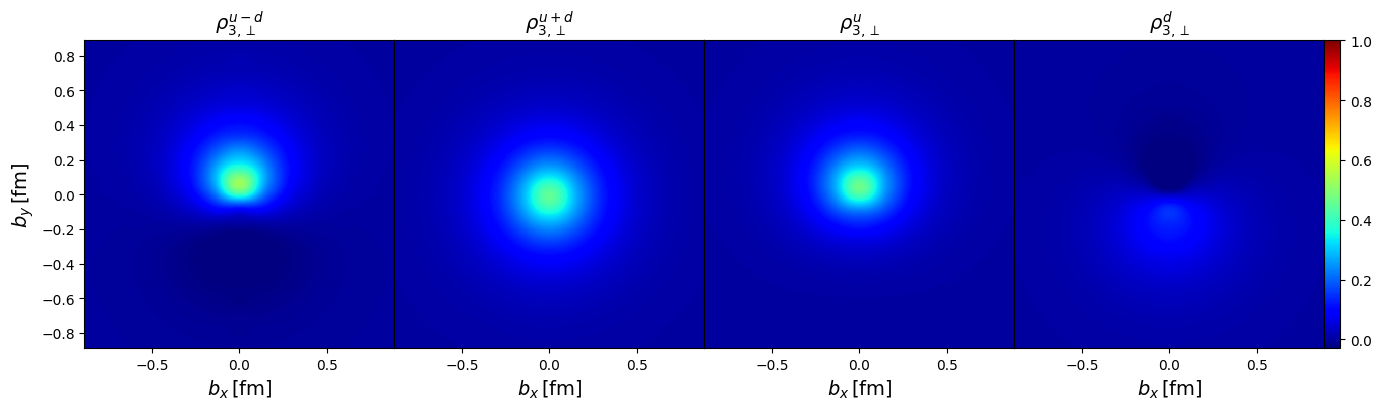

Saved data to /home/hechenvanmountain/stringy-gpds/data/ImpactParameterMoments/imp_param_transv_pol_moment_j_4_non_singlet_isovector_010_000_200.csv
Saved data to /home/hechenvanmountain/stringy-gpds/data/ImpactParameterMoments/imp_param_transv_pol_moment_j_4_non_singlet_isoscalar_010_000_200.csv
Saved data to /home/hechenvanmountain/stringy-gpds/data/ImpactParameterMoments/imp_param_transv_pol_moment_j_4_u_010_000_200.csv
Saved data to /home/hechenvanmountain/stringy-gpds/data/ImpactParameterMoments/imp_param_transv_pol_moment_j_4_d_010_000_200.csv


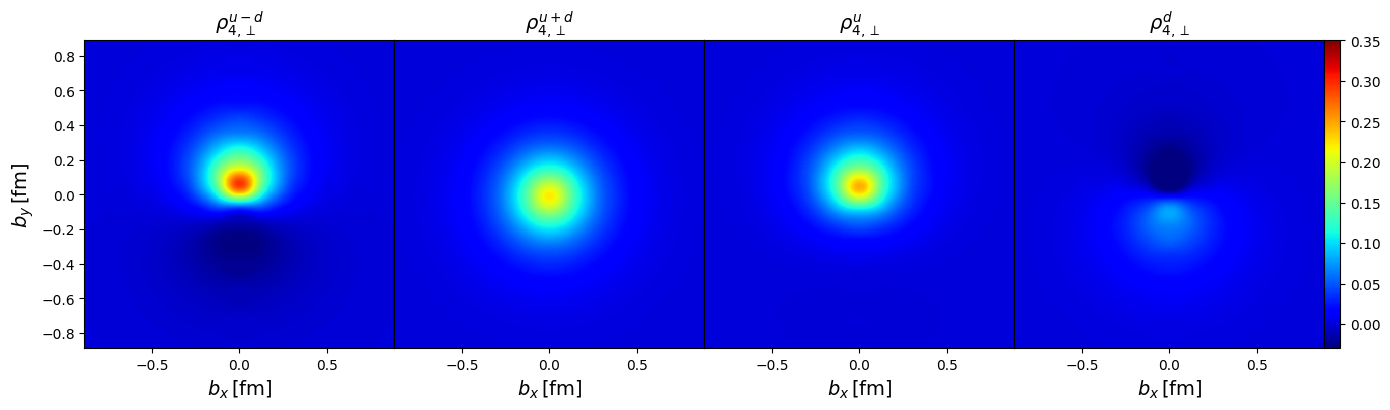

Saved data to /home/hechenvanmountain/stringy-gpds/data/ImpactParameterMoments/imp_param_transv_pol_moment_j_1_non_singlet_isovector_033_000_200.csv
Saved data to /home/hechenvanmountain/stringy-gpds/data/ImpactParameterMoments/imp_param_transv_pol_moment_j_1_non_singlet_isoscalar_033_000_200.csv
Saved data to /home/hechenvanmountain/stringy-gpds/data/ImpactParameterMoments/imp_param_transv_pol_moment_j_1_u_033_000_200.csv
Saved data to /home/hechenvanmountain/stringy-gpds/data/ImpactParameterMoments/imp_param_transv_pol_moment_j_1_d_033_000_200.csv


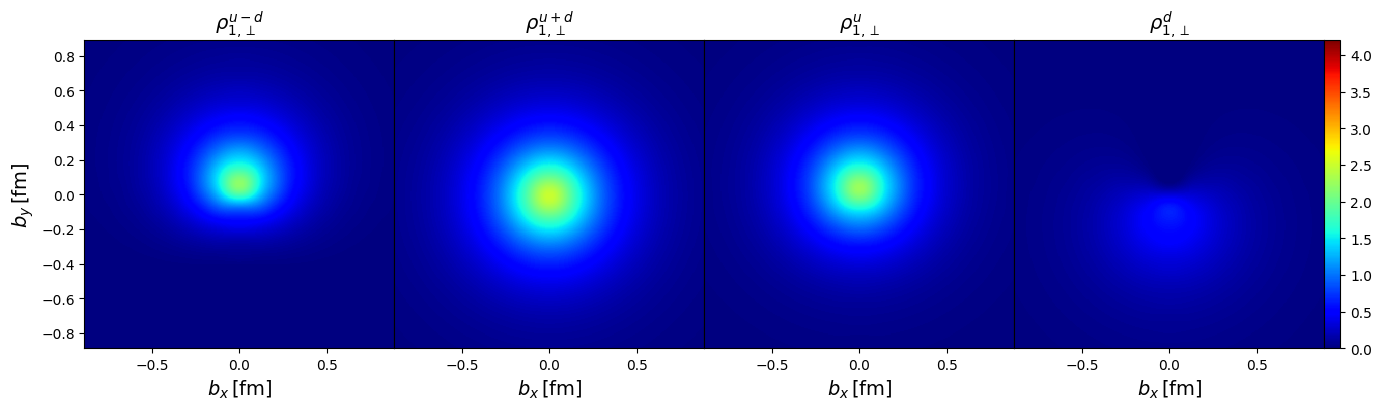

Saved data to /home/hechenvanmountain/stringy-gpds/data/ImpactParameterMoments/imp_param_transv_pol_moment_j_2_non_singlet_isovector_033_000_200.csv
Saved data to /home/hechenvanmountain/stringy-gpds/data/ImpactParameterMoments/imp_param_transv_pol_moment_j_2_non_singlet_isoscalar_033_000_200.csv
Saved data to /home/hechenvanmountain/stringy-gpds/data/ImpactParameterMoments/imp_param_transv_pol_moment_j_2_u_033_000_200.csv
Saved data to /home/hechenvanmountain/stringy-gpds/data/ImpactParameterMoments/imp_param_transv_pol_moment_j_2_d_033_000_200.csv


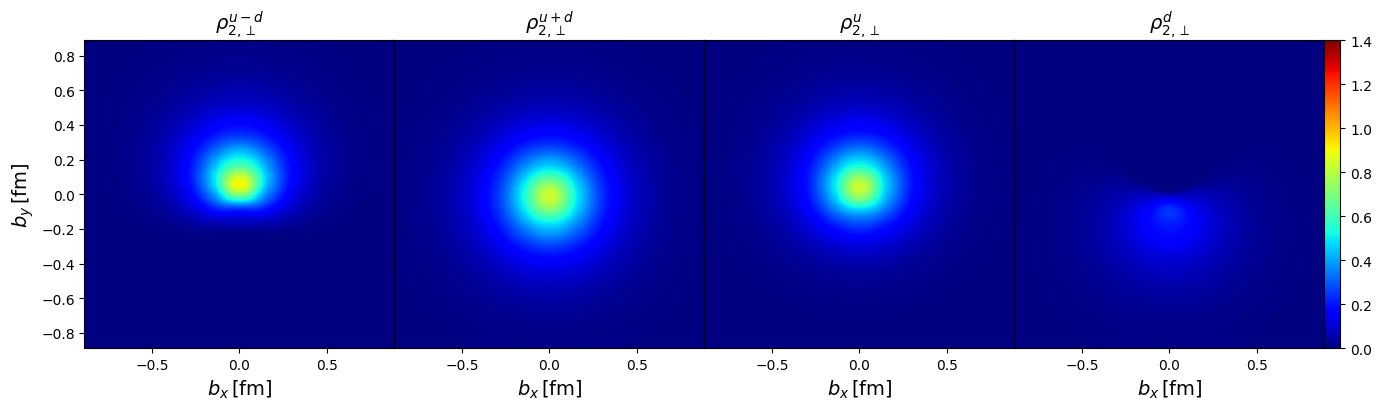

Saved data to /home/hechenvanmountain/stringy-gpds/data/ImpactParameterMoments/imp_param_transv_pol_moment_j_3_non_singlet_isovector_033_000_200.csv
Saved data to /home/hechenvanmountain/stringy-gpds/data/ImpactParameterMoments/imp_param_transv_pol_moment_j_3_non_singlet_isoscalar_033_000_200.csv
Saved data to /home/hechenvanmountain/stringy-gpds/data/ImpactParameterMoments/imp_param_transv_pol_moment_j_3_u_033_000_200.csv
Saved data to /home/hechenvanmountain/stringy-gpds/data/ImpactParameterMoments/imp_param_transv_pol_moment_j_3_d_033_000_200.csv


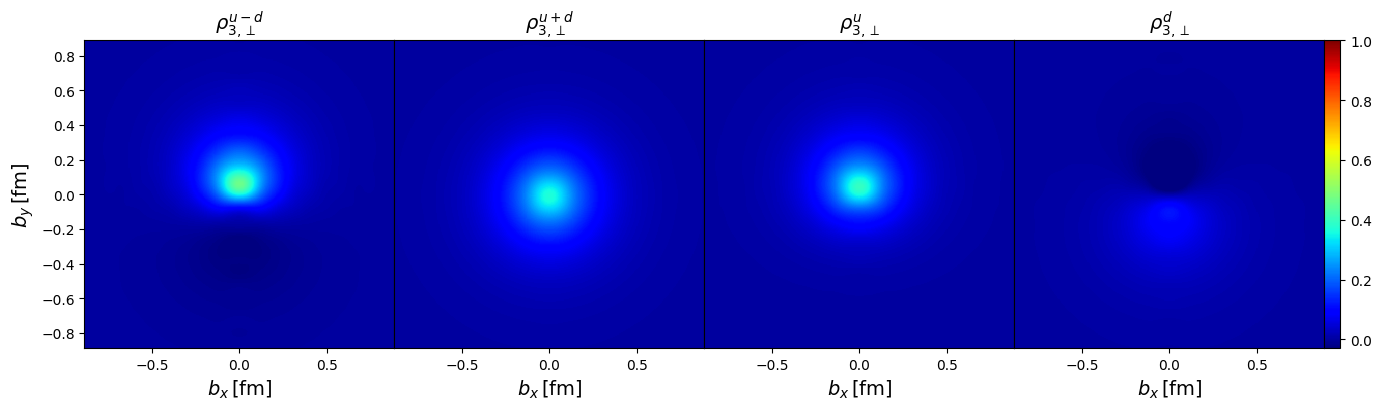

Saved data to /home/hechenvanmountain/stringy-gpds/data/ImpactParameterMoments/imp_param_transv_pol_moment_j_4_non_singlet_isovector_033_000_200.csv
Saved data to /home/hechenvanmountain/stringy-gpds/data/ImpactParameterMoments/imp_param_transv_pol_moment_j_4_non_singlet_isoscalar_033_000_200.csv
Saved data to /home/hechenvanmountain/stringy-gpds/data/ImpactParameterMoments/imp_param_transv_pol_moment_j_4_u_033_000_200.csv
Saved data to /home/hechenvanmountain/stringy-gpds/data/ImpactParameterMoments/imp_param_transv_pol_moment_j_4_d_033_000_200.csv


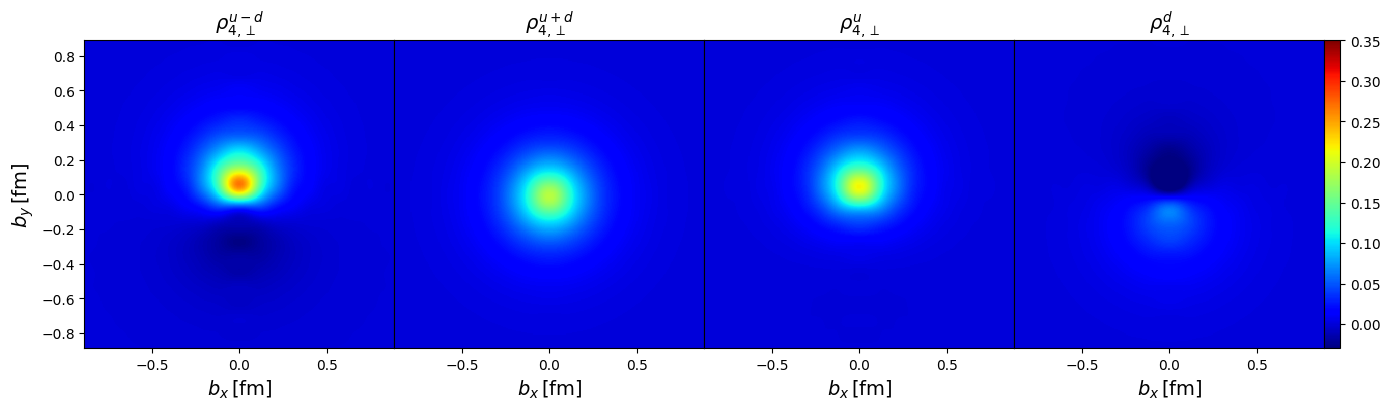

In [39]:
# Generate data for transversely polarized
# proton in impact parameter space
from stringy_gpds.plot import plot_fourier_transform_transverse_moments
for eta in [.1,1/3]:
    plot_fourier_transform_transverse_moments(1,eta,2,moment_type="all",read_from_file=False,write_to_file=True,interpolation=True,vmin=0, vmax=4.2,evolution_order="nlo")
    plot_fourier_transform_transverse_moments(2,eta,2,moment_type="all",read_from_file=False,write_to_file=True,interpolation=True,vmin=0, vmax=1.4,evolution_order="nlo")
    plot_fourier_transform_transverse_moments(3,eta,2,moment_type="all",read_from_file=False,write_to_file=True,interpolation=True,vmin=-.03, vmax=1,evolution_order="nlo")
    plot_fourier_transform_transverse_moments(4,eta,2,moment_type="all",read_from_file=False,write_to_file=True,interpolation=True,vmin=-.03, vmax=.35,evolution_order="nlo")

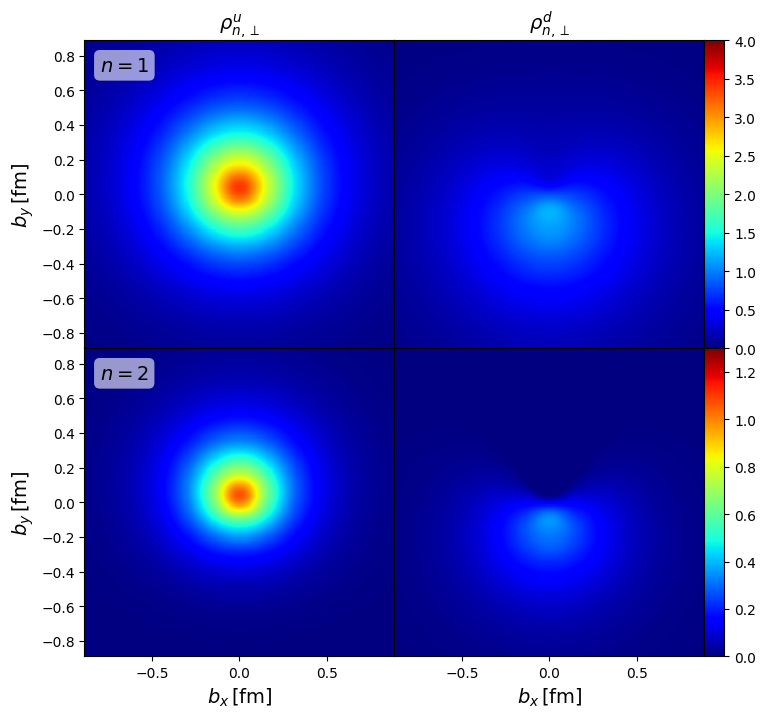

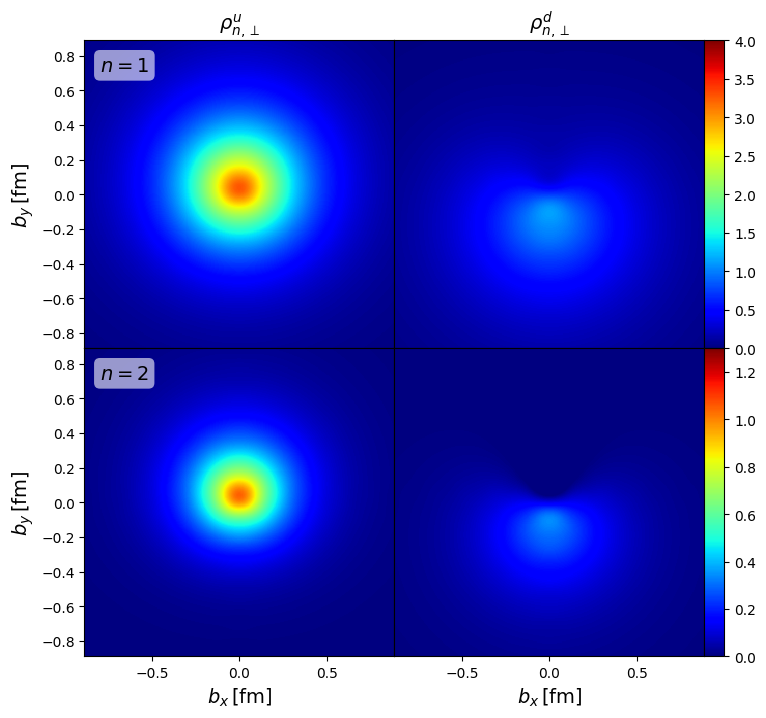

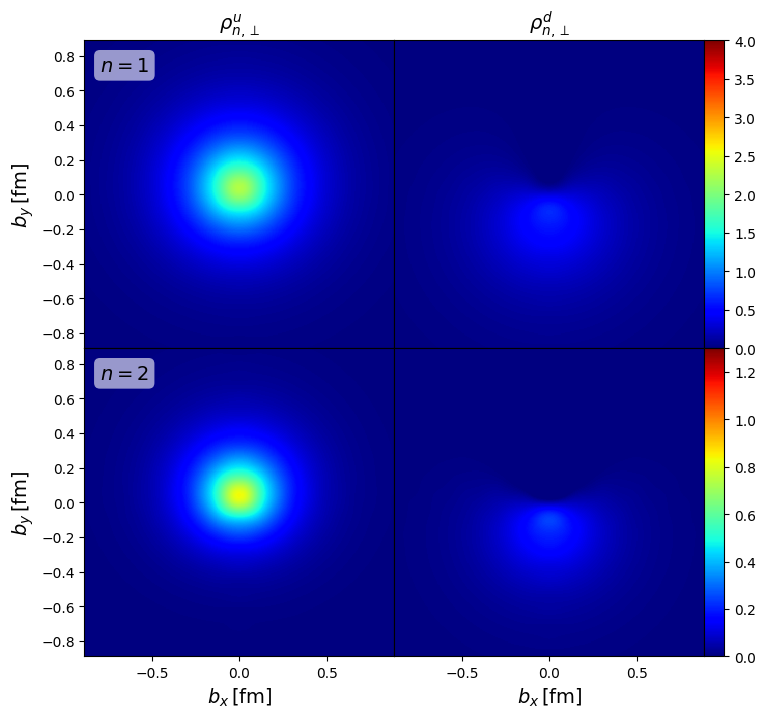

In [9]:
from scipy.interpolate import RectBivariateSpline
import stringy_gpds.helpers as hp
import stringy_gpds.config as cfg
import matplotlib.pyplot as plt
import numpy as np

def plot_fourier_transform_transverse_moments_ud_grid(n_max, eta, mu,
                                                   particle="quark", interpolation=True,
                                                   n_int=300, vmin=0, vmax=1):
    """
    Generate a grid of 2D density plots showing the Fourier transforms of 
    RGE-evolved conformal moments for a transversely polarized proton.

    The A and B moments are used automatically. All precomputed data tables 
    must have the same `b_max` and be present on the file system. Use 
    `plot_fourier_transform_transverse_moments` to generate them.

    Parameters
    ----------
    n_max : int
        Maximum conformal spin to include in the grid (plots for all n = 1, ..., n_max).
    eta : float
        Skewness parameter.
    mu : float
        Resolution scale in GeV.
    particle : str, optional
        "quark" or "gluon". Default is "quark".
    interpolation : bool, optional
        Whether to interpolate data onto a finer grid for smoother plots. Default is True.
    n_int : int, optional
        Number of points used in each interpolation dimension. Default is 300.
    vmin : float, optional
        Minimum value for the colormap (colorbar scale). Default is 0.
    vmax : float, optional
        Maximum value for the colormap (colorbar scale). Default is 1.

    Returns
    -------
    None

    Notes
    -----
    This function creates a 2D density plot of the Fourier-transformed conformal
    moments for a transversely polarized target. The plot is saved under
    cfg.PLOT_PATH / "imp_param_transv_pol_moments_{eta}_{t}_{mu}.pdf"
    where PLOT_PATH is defined in config.py.
    """

    def get_subplot_positions_and_heights(n_rows,n_cols):
        """
        Returns the positions and heights of each subplot in the grid.
        
        Returns:
        - A list of row heights and positions for each subplot.
        """
        row_positions_and_heights = []
        
        # Step 1: Create a hidden figure to determine subplot heights without labels/ticks
        fig_hidden, axs_hidden = plt.subplots(n_rows, n_cols, figsize=(n_cols * 4, n_rows*4))
        fig_hidden.subplots_adjust(wspace=0, hspace=0)  # Remove extra spacing
        
        for row in range(n_rows):
            # Get the bounding box (position and height) of the last column in each row
            bbox = axs_hidden[row,-1].get_position()
            row_positions_and_heights.append((bbox.x0, bbox.y0, bbox.width, bbox.height))  # Position (x0, y0), width, and height
        
        plt.close(fig_hidden)  # Close the hidden figure
        
        return row_positions_and_heights

            
    hp.check_particle_type(particle)

    if len(vmin)<n_max or len(vmax)<n_max:
        raise ValueError("Supply vmin and vmax as arrays of length n_max")

    prfx = "imp_param_transv_pol_moments_ud"
    file_name = hp.generate_filename(eta,0,mu,prfx,file_ext="pdf")
    FILE_PATH = cfg.PLOT_PATH / file_name

    moment_types = ["u", "d"]

    # Determine figure layout
    fig, axs = plt.subplots(n_max, len(moment_types), figsize=(len(moment_types) * 4, n_max*4))
    row_positions_and_heights = get_subplot_positions_and_heights(n_max,len(moment_types))

    title_map = {
        "u": "u",
        "d": "d"
    }

    for j in range(1, n_max + 1):
        for i, mom_type in enumerate(moment_types):
            # Import
            READ_WRITE_PATH = cfg.IMPACT_PARAMETER_MOMENTS_PATH /  f"imp_param_transv_pol_moment_j_{j}_{mom_type}"
            file_name = hp.generate_filename(eta,0,mu,READ_WRITE_PATH,"central")
            b_x_fm, b_y_fm, fourier_transform_moment_values_flat = hp.read_ft_from_csv(file_name)
            # Plot layout and title
            row, col = j-1, i
            ax = axs[row, col]
            title = title_map[mom_type]

            if interpolation:
                b_max = max(b_x_fm)
                ft_interpolation = RectBivariateSpline(b_x_fm, b_y_fm, fourier_transform_moment_values_flat)

                # Call the interpolation on a finer grid
                b_x_fm = np.linspace(-b_max, b_max, n_int)
                b_y_fm = np.linspace(-b_max, b_max, n_int)

                fourier_transform_moment_values_flat = ft_interpolation(b_x_fm, b_y_fm)

            # Generate 2D density plot
            im = ax.pcolormesh(b_x_fm, b_y_fm, fourier_transform_moment_values_flat, 
                                shading='auto', cmap='jet',vmin=vmin[j-1], vmax=vmax[j-1],rasterized=True)
            ax.set_xlabel(r'$b_x\,[\mathrm{fm}]$', fontsize=14)
            if i == 0:
                ax.set_ylabel(r'$b_y\,[\mathrm{fm}]$', fontsize=14)
            if j == 1:
                ax.set_title(rf"$\rho_{{n,\perp}}^{{{title}}}$", fontsize=14)

            ax.set_xlim([-b_max, b_max])
            ax.set_ylim([-b_max, b_max])
            
            if col == len(moment_types)-1:
                # print(ax.get_position().x1, ax.get_position().y0,ax.get_position().height)
                # Get positions without labels
                x0, y0, width, height = row_positions_and_heights[row]
                # We shift the x position by the width of the plot
                # such that it attaches to the right
                x0 += width
                cbar_ax = fig.add_axes([x0, y0, 0.025, height])
                fig.colorbar(im, cax=cbar_ax)
            if col == 0:
                ax.text(
                    0.05, 0.95,  
                    rf"$n={j}$",  
                    transform=ax.transAxes, 
                    ha='left', va='top', 
                    fontsize=14, color='black', fontweight='bold',
                    bbox=dict(facecolor='white', alpha=0.6, edgecolor='none', boxstyle='round,pad=0.3')  # Adds a semi-transparent background
                )

            # Remove ticks and labels
            if i != 0:
                ax.set_yticks([])
                ax.set_yticklabels([])
                ax.set_ylabel(None)
            if j != n_max:
                ax.set_xticks([])
                ax.set_xticklabels([])
                ax.set_xlabel(None)

    plt.subplots_adjust(wspace=0, hspace=0)


    # File export
    plt.savefig(FILE_PATH,format="pdf",bbox_inches="tight",dpi=600)

    # Adjust layout and show the plot
    plt.show()
    plt.close()

plot_fourier_transform_transverse_moments_ud_grid(2,0,2,vmin=[0,0],vmax=[4,1.3])
plot_fourier_transform_transverse_moments_ud_grid(2,.1,2,vmin=[0,0],vmax=[4,1.3])
plot_fourier_transform_transverse_moments_ud_grid(2,.33,2,vmin=[0,0],vmax=[4,1.3])

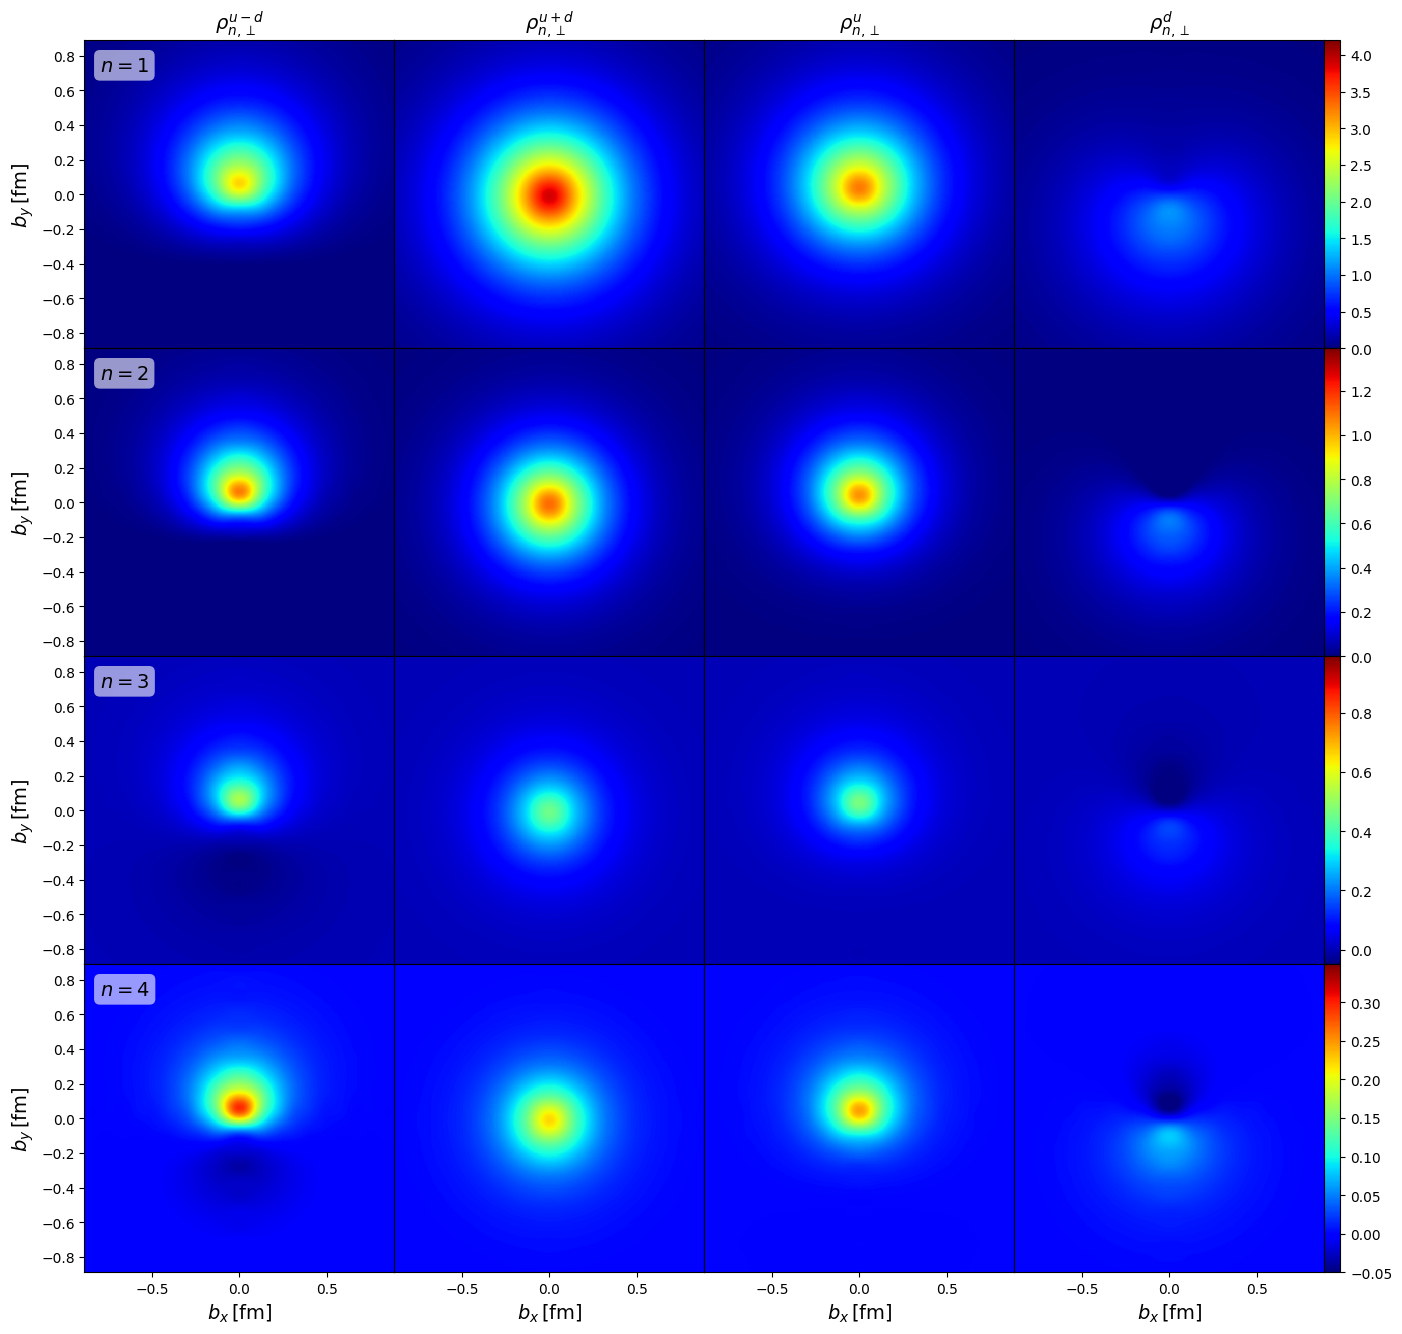

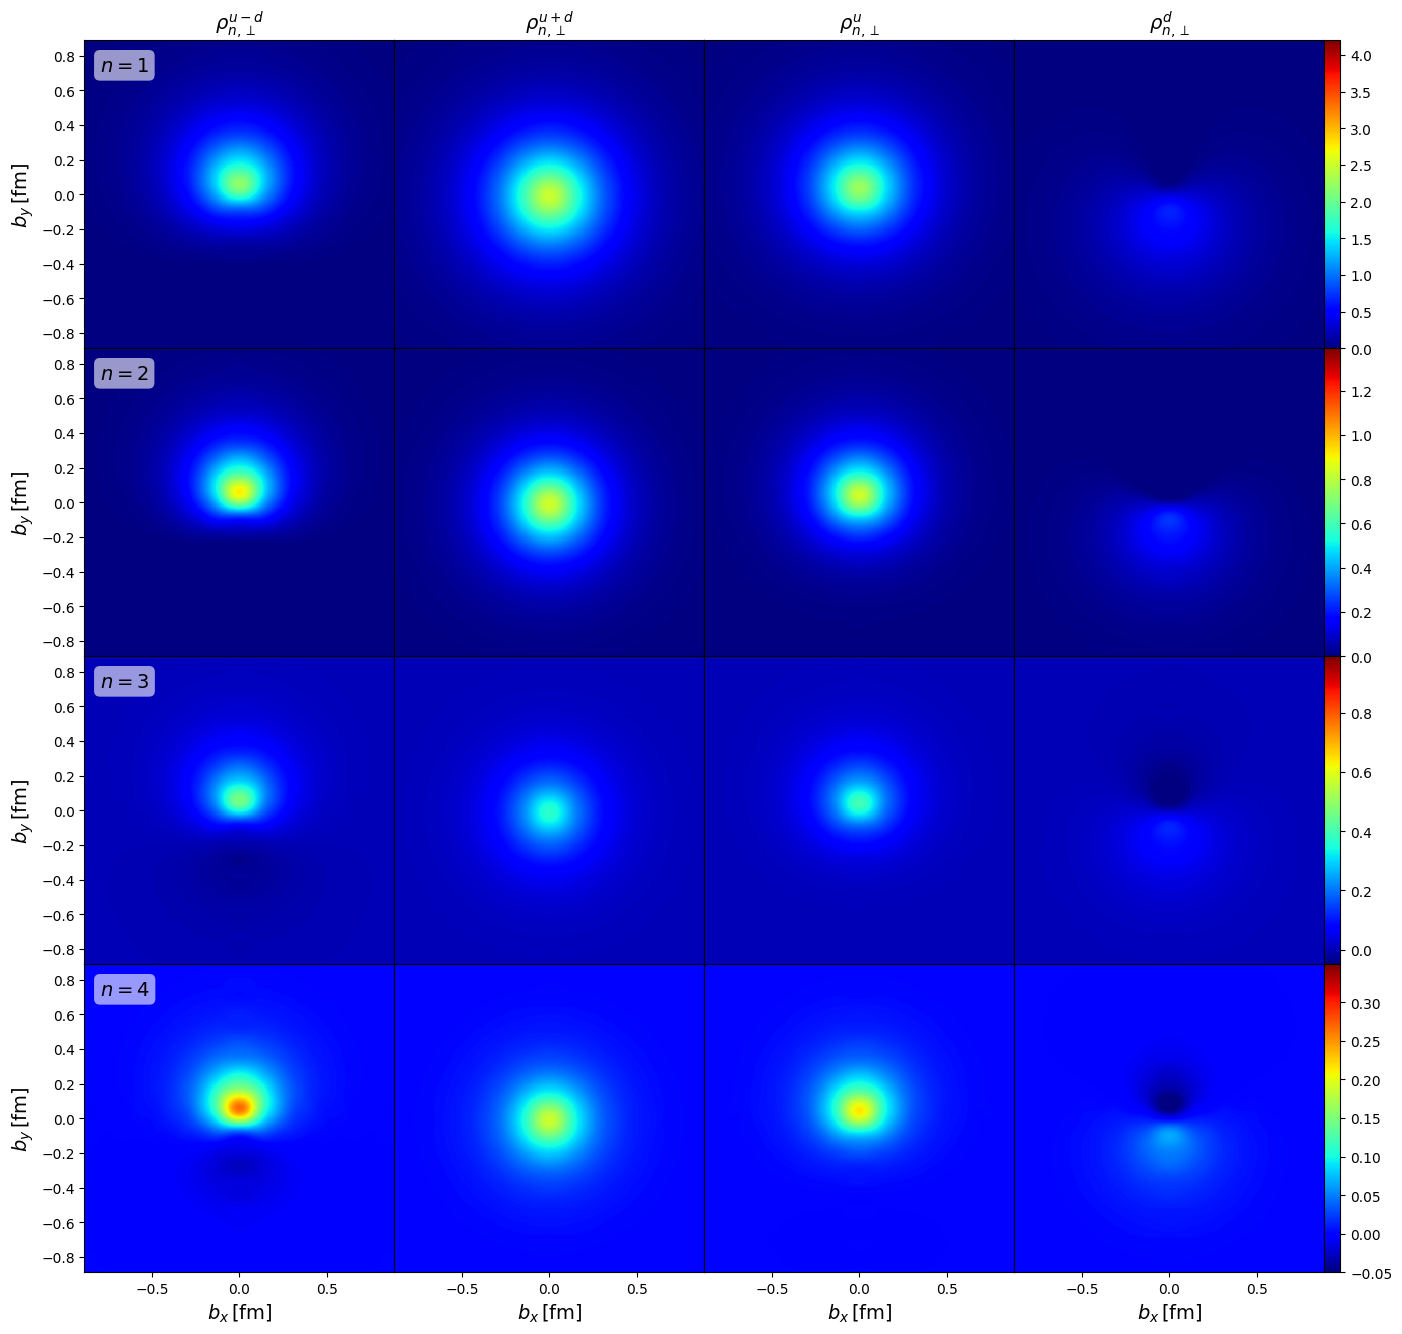

In [1]:
from stringy_gpds.plot import plot_fourier_transform_transverse_moments_grid
plot_fourier_transform_transverse_moments_grid(4,.1,2,vmin=[0,0,-0.05,-0.05],vmax=[4.2,1.39,.99,.349])
plot_fourier_transform_transverse_moments_grid(4,.33,2,vmin=[0,0,-0.05,-0.05],vmax=[4.2,1.39,.99,.349])

Saved data to /home/hechenvanmountain/stringy-gpds/data/ImpactParameterMoments/imp_param_helicity_singlet_quark_010_000_200.csv
Saved data to /home/hechenvanmountain/stringy-gpds/data/ImpactParameterMoments/imp_param_helicity_singlet_quark_010_000_200_plus.csv
Saved data to /home/hechenvanmountain/stringy-gpds/data/ImpactParameterMoments/imp_param_helicity_singlet_quark_010_000_200_minus.csv


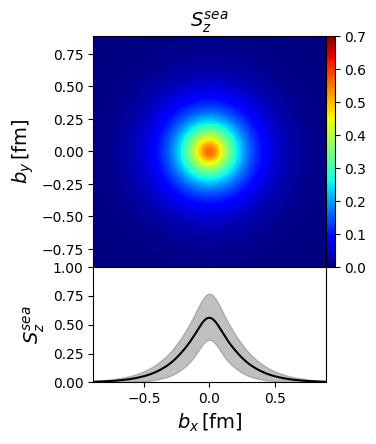

Saved data to /home/hechenvanmountain/stringy-gpds/data/ImpactParameterMoments/imp_param_helicity_singlet_gluon_010_000_200.csv
Saved data to /home/hechenvanmountain/stringy-gpds/data/ImpactParameterMoments/imp_param_helicity_singlet_gluon_010_000_200_plus.csv
Saved data to /home/hechenvanmountain/stringy-gpds/data/ImpactParameterMoments/imp_param_helicity_singlet_gluon_010_000_200_minus.csv


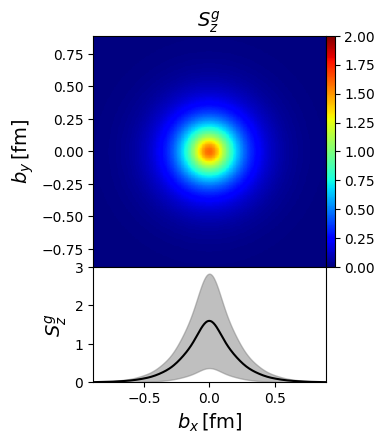

Saved data to /home/hechenvanmountain/stringy-gpds/data/ImpactParameterMoments/imp_param_helicity_non_singlet_isovector_010_000_200.csv
Saved data to /home/hechenvanmountain/stringy-gpds/data/ImpactParameterMoments/imp_param_helicity_non_singlet_isovector_010_000_200_plus.csv
Saved data to /home/hechenvanmountain/stringy-gpds/data/ImpactParameterMoments/imp_param_helicity_non_singlet_isovector_010_000_200_minus.csv
Saved data to /home/hechenvanmountain/stringy-gpds/data/ImpactParameterMoments/imp_param_helicity_non_singlet_isoscalar_010_000_200.csv
Saved data to /home/hechenvanmountain/stringy-gpds/data/ImpactParameterMoments/imp_param_helicity_non_singlet_isoscalar_010_000_200_plus.csv
Saved data to /home/hechenvanmountain/stringy-gpds/data/ImpactParameterMoments/imp_param_helicity_non_singlet_isoscalar_010_000_200_minus.csv
Saved data to /home/hechenvanmountain/stringy-gpds/data/ImpactParameterMoments/imp_param_helicity_u_010_000_200.csv
Saved data to /home/hechenvanmountain/stringy-

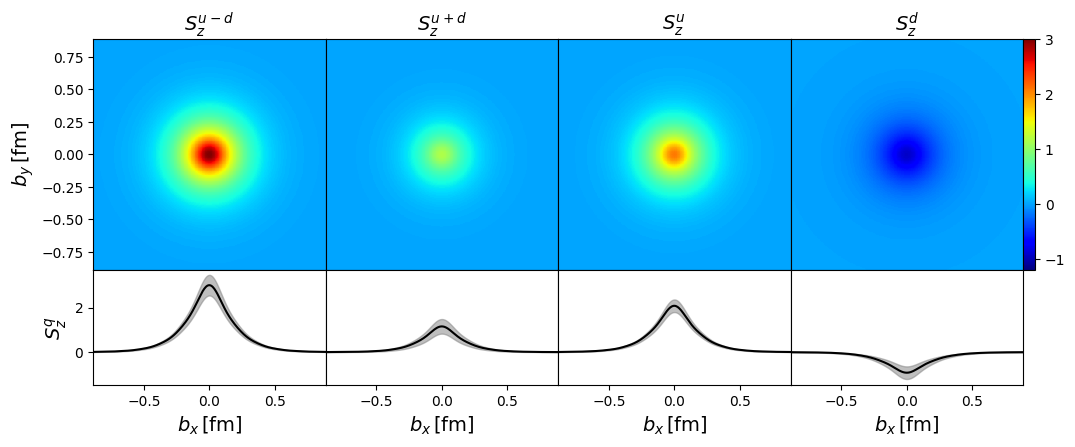

Saved data to /home/hechenvanmountain/stringy-gpds/data/ImpactParameterMoments/imp_param_spin_orbit_non_singlet_isovector_010_000_200.csv
Saved data to /home/hechenvanmountain/stringy-gpds/data/ImpactParameterMoments/imp_param_spin_orbit_non_singlet_isovector_010_000_200_plus.csv
Saved data to /home/hechenvanmountain/stringy-gpds/data/ImpactParameterMoments/imp_param_spin_orbit_non_singlet_isovector_010_000_200_minus.csv
Saved data to /home/hechenvanmountain/stringy-gpds/data/ImpactParameterMoments/imp_param_spin_orbit_non_singlet_isoscalar_010_000_200.csv
Saved data to /home/hechenvanmountain/stringy-gpds/data/ImpactParameterMoments/imp_param_spin_orbit_non_singlet_isoscalar_010_000_200_plus.csv
Saved data to /home/hechenvanmountain/stringy-gpds/data/ImpactParameterMoments/imp_param_spin_orbit_non_singlet_isoscalar_010_000_200_minus.csv
Saved data to /home/hechenvanmountain/stringy-gpds/data/ImpactParameterMoments/imp_param_spin_orbit_u_010_000_200.csv
Saved data to /home/hechenvanmou

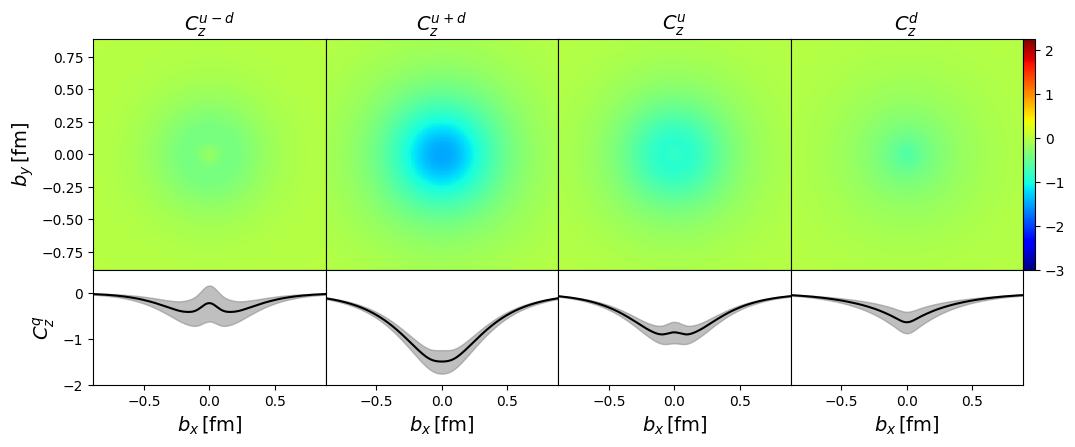

Saved data to /home/hechenvanmountain/stringy-gpds/data/ImpactParameterMoments/imp_param_oam_non_singlet_isovector_010_000_200.csv
Saved data to /home/hechenvanmountain/stringy-gpds/data/ImpactParameterMoments/imp_param_oam_non_singlet_isovector_010_000_200_plus.csv
Saved data to /home/hechenvanmountain/stringy-gpds/data/ImpactParameterMoments/imp_param_oam_non_singlet_isovector_010_000_200_minus.csv
Saved data to /home/hechenvanmountain/stringy-gpds/data/ImpactParameterMoments/imp_param_oam_non_singlet_isoscalar_010_000_200.csv
Saved data to /home/hechenvanmountain/stringy-gpds/data/ImpactParameterMoments/imp_param_oam_non_singlet_isoscalar_010_000_200_plus.csv
Saved data to /home/hechenvanmountain/stringy-gpds/data/ImpactParameterMoments/imp_param_oam_non_singlet_isoscalar_010_000_200_minus.csv
Saved data to /home/hechenvanmountain/stringy-gpds/data/ImpactParameterMoments/imp_param_oam_u_010_000_200.csv
Saved data to /home/hechenvanmountain/stringy-gpds/data/ImpactParameterMoments/im

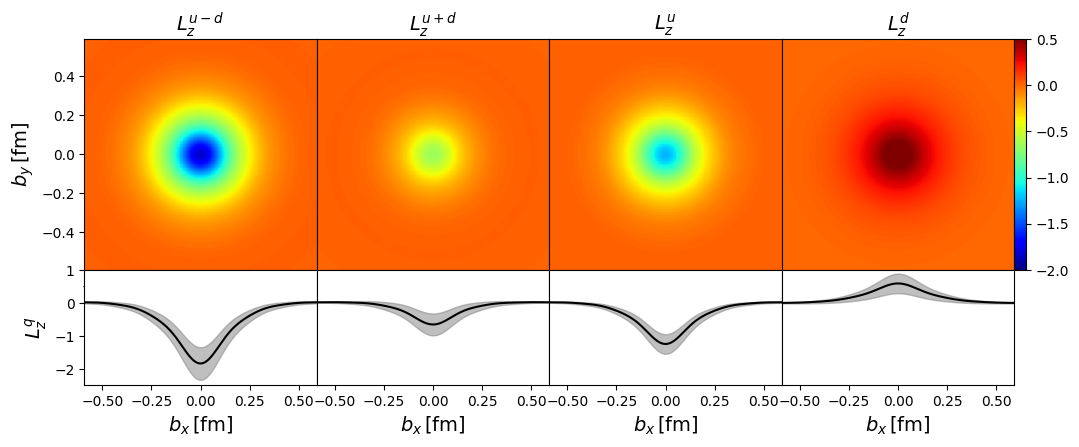

Saved data to /home/hechenvanmountain/stringy-gpds/data/ImpactParameterMoments/imp_param_helicity_singlet_quark_033_000_200.csv
Saved data to /home/hechenvanmountain/stringy-gpds/data/ImpactParameterMoments/imp_param_helicity_singlet_quark_033_000_200_plus.csv
Saved data to /home/hechenvanmountain/stringy-gpds/data/ImpactParameterMoments/imp_param_helicity_singlet_quark_033_000_200_minus.csv


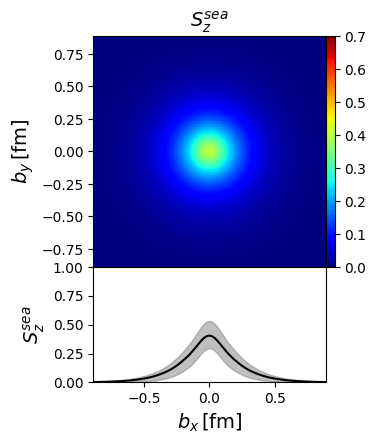

Saved data to /home/hechenvanmountain/stringy-gpds/data/ImpactParameterMoments/imp_param_helicity_singlet_gluon_033_000_200.csv
Saved data to /home/hechenvanmountain/stringy-gpds/data/ImpactParameterMoments/imp_param_helicity_singlet_gluon_033_000_200_plus.csv
Saved data to /home/hechenvanmountain/stringy-gpds/data/ImpactParameterMoments/imp_param_helicity_singlet_gluon_033_000_200_minus.csv


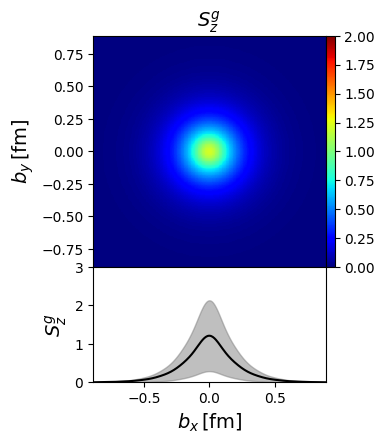

Saved data to /home/hechenvanmountain/stringy-gpds/data/ImpactParameterMoments/imp_param_helicity_non_singlet_isovector_033_000_200.csv
Saved data to /home/hechenvanmountain/stringy-gpds/data/ImpactParameterMoments/imp_param_helicity_non_singlet_isovector_033_000_200_plus.csv
Saved data to /home/hechenvanmountain/stringy-gpds/data/ImpactParameterMoments/imp_param_helicity_non_singlet_isovector_033_000_200_minus.csv
Saved data to /home/hechenvanmountain/stringy-gpds/data/ImpactParameterMoments/imp_param_helicity_non_singlet_isoscalar_033_000_200.csv
Saved data to /home/hechenvanmountain/stringy-gpds/data/ImpactParameterMoments/imp_param_helicity_non_singlet_isoscalar_033_000_200_plus.csv
Saved data to /home/hechenvanmountain/stringy-gpds/data/ImpactParameterMoments/imp_param_helicity_non_singlet_isoscalar_033_000_200_minus.csv
Saved data to /home/hechenvanmountain/stringy-gpds/data/ImpactParameterMoments/imp_param_helicity_u_033_000_200.csv
Saved data to /home/hechenvanmountain/stringy-

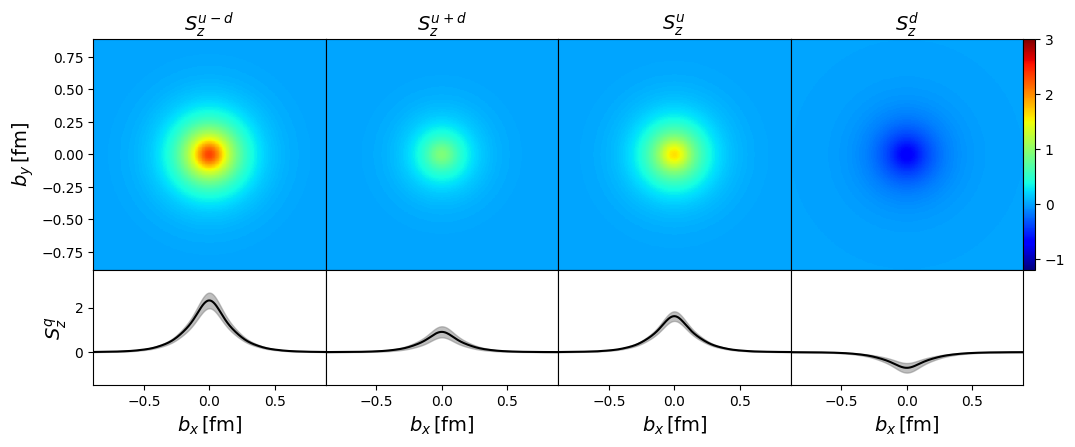

Saved data to /home/hechenvanmountain/stringy-gpds/data/ImpactParameterMoments/imp_param_spin_orbit_non_singlet_isovector_033_000_200.csv
Saved data to /home/hechenvanmountain/stringy-gpds/data/ImpactParameterMoments/imp_param_spin_orbit_non_singlet_isovector_033_000_200_plus.csv
Saved data to /home/hechenvanmountain/stringy-gpds/data/ImpactParameterMoments/imp_param_spin_orbit_non_singlet_isovector_033_000_200_minus.csv
Saved data to /home/hechenvanmountain/stringy-gpds/data/ImpactParameterMoments/imp_param_spin_orbit_non_singlet_isoscalar_033_000_200.csv
Saved data to /home/hechenvanmountain/stringy-gpds/data/ImpactParameterMoments/imp_param_spin_orbit_non_singlet_isoscalar_033_000_200_plus.csv
Saved data to /home/hechenvanmountain/stringy-gpds/data/ImpactParameterMoments/imp_param_spin_orbit_non_singlet_isoscalar_033_000_200_minus.csv
Saved data to /home/hechenvanmountain/stringy-gpds/data/ImpactParameterMoments/imp_param_spin_orbit_u_033_000_200.csv
Saved data to /home/hechenvanmou

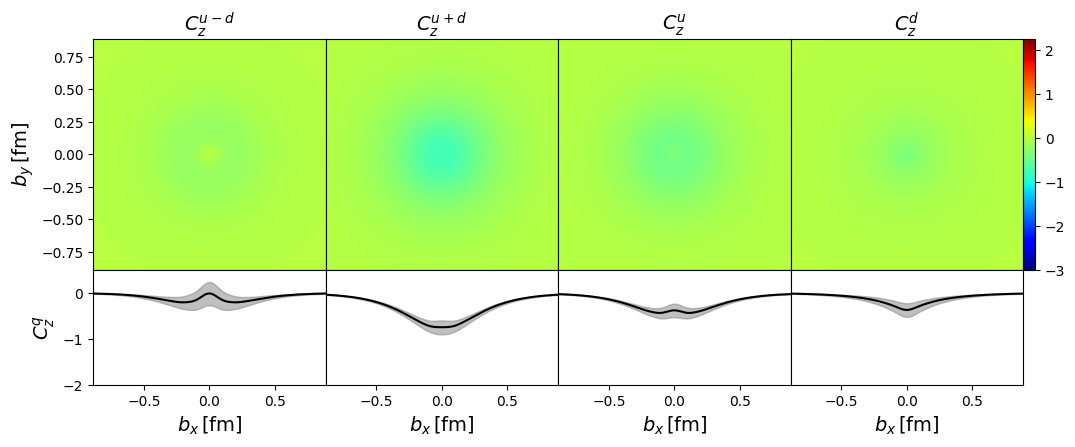

Saved data to /home/hechenvanmountain/stringy-gpds/data/ImpactParameterMoments/imp_param_oam_non_singlet_isovector_033_000_200.csv
Saved data to /home/hechenvanmountain/stringy-gpds/data/ImpactParameterMoments/imp_param_oam_non_singlet_isovector_033_000_200_plus.csv
Saved data to /home/hechenvanmountain/stringy-gpds/data/ImpactParameterMoments/imp_param_oam_non_singlet_isovector_033_000_200_minus.csv
Saved data to /home/hechenvanmountain/stringy-gpds/data/ImpactParameterMoments/imp_param_oam_non_singlet_isoscalar_033_000_200.csv
Saved data to /home/hechenvanmountain/stringy-gpds/data/ImpactParameterMoments/imp_param_oam_non_singlet_isoscalar_033_000_200_plus.csv
Saved data to /home/hechenvanmountain/stringy-gpds/data/ImpactParameterMoments/imp_param_oam_non_singlet_isoscalar_033_000_200_minus.csv
Saved data to /home/hechenvanmountain/stringy-gpds/data/ImpactParameterMoments/imp_param_oam_u_033_000_200.csv
Saved data to /home/hechenvanmountain/stringy-gpds/data/ImpactParameterMoments/im

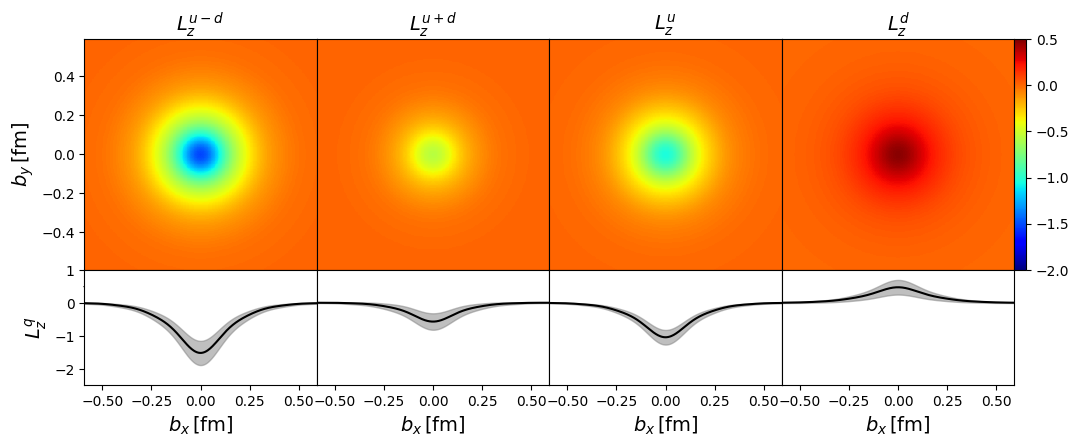

In [38]:
from stringy_gpds.plot import plot_fourier_transform_quark_helicity, plot_fourier_transform_quark_spin_orbit_correlation, plot_fourier_transform_quark_orbital_angular_momentum, plot_fourier_transform_singlet_helicity
for eta in [.1,1/3]:
    plot_fourier_transform_singlet_helicity(eta,2,particle="quark",vmin=0,vmax=.7,ymin=0,ymax=1,read_from_file=False,write_to_file=True)
    plot_fourier_transform_singlet_helicity(eta,2,particle="gluon",vmin=0,vmax=2,ymin=0,ymax=3,read_from_file=False,write_to_file=True)
    plot_fourier_transform_quark_helicity(eta,2,moment_type="all",read_from_file=False,write_to_file=True,ymin=-1.5,ymax=3.7,vmin=-1.2,vmax=3)
    plot_fourier_transform_quark_spin_orbit_correlation(eta,2,moment_type="all",read_from_file=False,write_to_file=True,ymin=-2,ymax=.5,vmin=-3,vmax=2.25)
    plot_fourier_transform_quark_orbital_angular_momentum(eta,2,moment_type="all",read_from_file=False,write_to_file=True,ymin=-2.5,ymax=1,vmin=-2,vmax=.5)

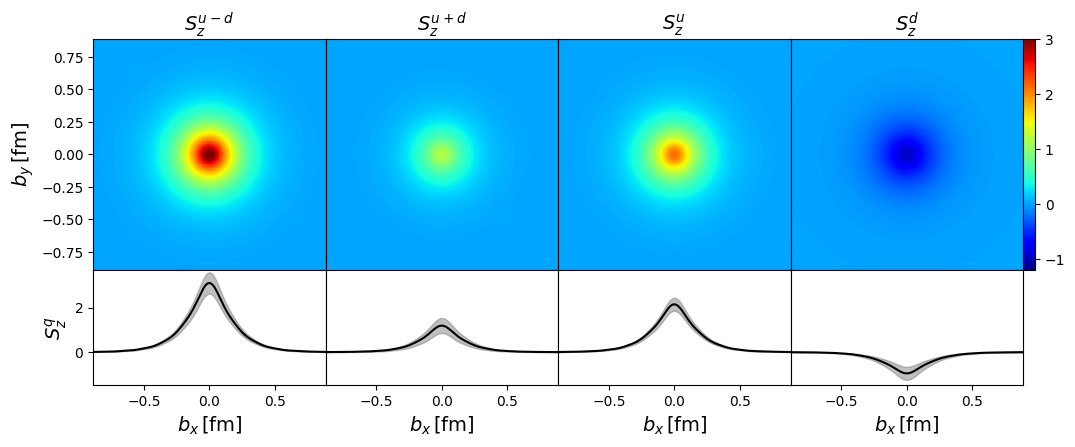

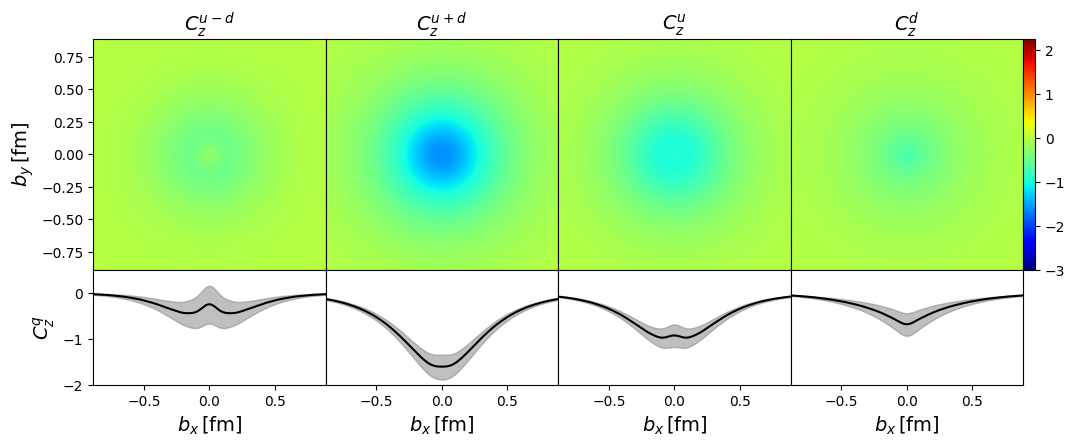

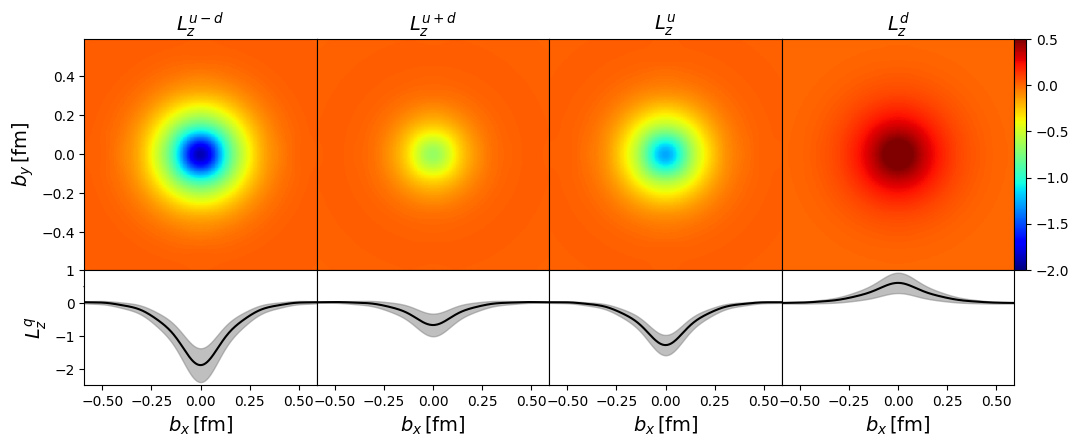

In [6]:
from stringy_gpds import plot_fourier_transform_quark_helicity, plot_fourier_transform_quark_spin_orbit_correlation, plot_fourier_transform_quark_orbital_angular_momentum
plot_fourier_transform_quark_helicity(0,2,moment_type="all",read_from_file=False,write_to_file=True,ymin=-1.5,ymax=3.7,vmin=-1.2,vmax=3)
plot_fourier_transform_quark_spin_orbit_correlation(0,2,moment_type="all",read_from_file=False,write_to_file=True,ymin=-2,ymax=.5,vmin=-3,vmax=2.25)
plot_fourier_transform_quark_orbital_angular_momentum(0,2,moment_type="all",read_from_file=False,write_to_file=True,ymin=-2.5,ymax=1,vmin=-2,vmax=.5)

In [ ]:
# Generate data for transversely polarized
# proton in impact parameter space
from stringy_gpds import plot_fourier_transform_transverse_moments
plot_fourier_transform_transverse_moments(1,0,2,moment_type="all",read_from_file=False,write_to_file=True,interpolation=True,vmin=0, vmax=4.2,evolution_order="nlo")
plot_fourier_transform_transverse_moments(2,0,2,moment_type="all",read_from_file=False,write_to_file=True,interpolation=True,vmin=0, vmax=1.4,evolution_order="nlo")
plot_fourier_transform_transverse_moments(3,0,2,moment_type="all",read_from_file=False,write_to_file=True,interpolation=True,vmin=-.03, vmax=1,evolution_order="nlo")
plot_fourier_transform_transverse_moments(4,0,2,moment_type="all",read_from_file=False,write_to_file=True,interpolation=True,vmin=-.03, vmax=.35,evolution_order="nlo")

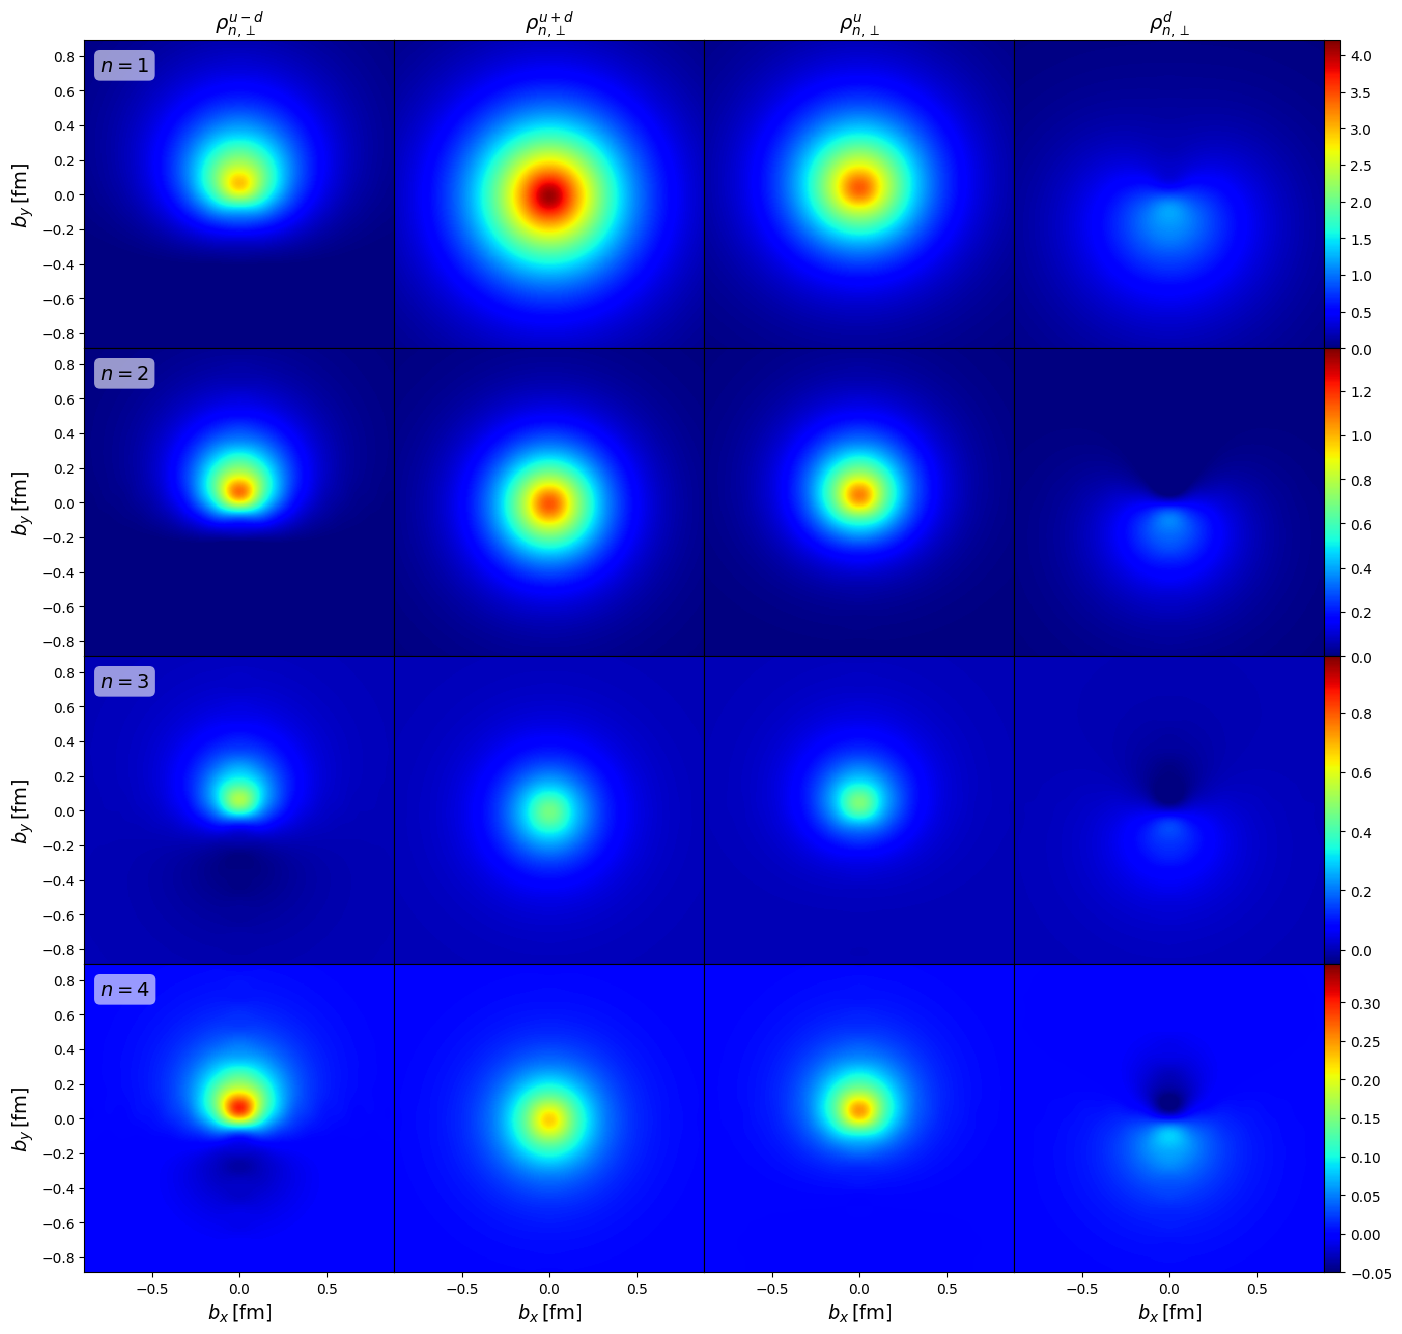

In [ ]:
# Display all transverse moments on a grid
from stringy_gpds.plot import plot_fourier_transform_transverse_moments_grid
plot_fourier_transform_transverse_moments_grid(4,0,2,vmin=[0,0,-0.05,-0.05],vmax=[4.2,1.39,.99,.349])

Spin sum rule quantities

In [11]:
from stringy_gpds import (
    orbital_angular_momentum,spin_orbit_corelation,quark_helicity,gluon_helicity,total_spin
)
import numpy as np

In [27]:
mu = 1
s_u_minus_d, s_u_minus_d_plus, s_u_minus_d_minus = quark_helicity(0,0,mu,moment_type="non_singlet_isovector")
s_u_plus_d, s_u_plus_d_plus, s_u_plus_d_minus = quark_helicity(0,0,mu,moment_type="non_singlet_isoscalar")
s_sea, s_sea_plus, s_sea_minus= quark_helicity(0,0,mu,moment_type="singlet")
s_g, s_g_plus, s_g_minus = gluon_helicity(0,0,mu)
s_u = (s_u_plus_d+s_u_minus_d)/2
s_u_plus = np.sqrt(s_u_minus_d_plus**2+s_u_plus_d_plus**2)/2
s_u_minus = np.sqrt(s_u_minus_d_minus**2+s_u_plus_d_minus**2)/2
s_d = (s_u_plus_d-s_u_minus_d)/2
s_s = s_sea - s_u - s_d
s_s_plus = np.sqrt(s_sea_plus**2 + 2 * s_u_plus**2)
s_s_minus = np.sqrt(s_sea_minus**2 + 2 * s_u_minus**2)
# print(s_u_minus_d,s_u_minus_d_minus,s_u_minus_d_plus)
# print(s_u_plus_d,s_u_plus_d_plus,s_u_plus_d_minus)
print("u")
print(s_u,s_u_plus,s_u_minus)
print("d")
print(s_d,s_u_plus,s_u_minus)
print("s")
print(s_s,s_s_plus,s_s_minus)
print("sea")
print(s_sea, s_sea_plus , s_sea_minus)
print("g")
print(s_g,s_g_plus,s_g_minus)
print(s_u+s_d+s_s+s_g,np.sqrt(2*s_u_plus**2+s_s_plus**2+s_g_plus**2),np.sqrt(2*s_u_minus**2+s_s_minus**2+s_g_minus**2))

u
0.42072267837761623 0.06650765755083389 0.06650765755083389
d
-0.20964013335007958 0.06650765755083389 0.06650765755083389
s
-0.026529818883290618 0.18491842204672548 0.18491842204672548
sea
0.18455272614424603 0.15921144992258848 0.15921144992258848
g
0.15600024702902826 0.1887690087130433 0.1887690087130433
0.34055297317327426 0.2804908171198371 0.2804908171198371


In [28]:
mu = 1
l_u_minus_d, l_u_minus_d_plus ,l_u_minus_d_minus = orbital_angular_momentum(0,0,mu)
l_u_plus_d, l_u_plus_d_plus ,l_u_plus_d_minus = orbital_angular_momentum(0,0,mu,moment_type="non_singlet_isoscalar")
l_sea, l_sea_plus , l_sea_minus = orbital_angular_momentum(0,0,mu,moment_type="singlet")
l_g, l_g_plus, l_g_minus = orbital_angular_momentum(0,0,mu,moment_type="singlet",particle="gluon")
l_u = (l_u_minus_d + l_u_plus_d)/2
l_d = (l_u_plus_d - l_u_minus_d)/2
l_u_plus = np.sqrt(l_u_minus_d_plus**2+l_u_plus_d_plus**2)/2
l_u_minus = np.sqrt(l_u_minus_d_minus**2+l_u_plus_d_minus**2)/2
l_s = l_sea - l_u - l_d
l_s_plus = np.sqrt(l_sea_plus**2 + 2 * l_u_plus**2)
l_s_minus = np.sqrt(l_sea_minus**2 + 2 * l_u_minus**2)
# print(l_u_plus_d,l_u_plus_d_plus,l_u_plus_d_minus)
# print(l_u_minus_d,l_u_minus_d_plus,l_u_minus_d_minus)
print("u")
print(l_u,l_u_plus,l_u_minus)
print("d")
print(l_d,l_u_plus,l_u_minus)
print("s")
print(l_s,l_s_plus,l_s_minus)
print("sea")
print(l_sea, l_sea_plus , l_sea_minus)
print("g")
print(l_g,l_g_plus,l_g_minus)
print(l_u+l_d+l_s+l_g,np.sqrt(2*l_u_plus**2+l_s_plus**2+l_g_plus**2),np.sqrt(2*l_u_minus**2+l_s_minus**2+l_g_minus**2))

u
-0.07119123470138088 0.08668518039220174 0.08947018901381654
d
0.06643379526202971 0.08668518039220174 0.08947018901381654
s
0.14084175067045662 0.2093710429625069 0.2105375103624606
sea
0.13608431123110545 0.16972799601701186 0.16827422210572568
g
0.0233597851971859 0.20573063010311377 0.2030551480504693
0.15944409642829135 0.31810370446300884 0.3186961968140776


In [29]:
mu = 1
j_u_minus_d, j_u_minus_d_plus, j_u_minus_d_minus =  total_spin(0,0,mu,particle="quark",moment_type="non_singlet_isovector",evolution_order="nlo")
j_u_plus_d, j_u_plus_d_plus, j_u_plus_d_minus =  total_spin(0,0,mu,particle="quark",moment_type="non_singlet_isoscalar",evolution_order="nlo")
j_sea, j_sea_plus, j_sea_minus =  total_spin(0,0,mu,particle="quark",moment_type="singlet",evolution_order="nlo")
j_g,j_g_plus,j_g_minus=  total_spin(0,0,mu,particle="gluon",moment_type="singlet",evolution_order="nlo")
j_u = (j_u_plus_d+j_u_minus_d)/2
j_u_plus = np.sqrt(j_u_minus_d_plus**2+j_u_plus_d_plus**2)/2
j_u_minus = np.sqrt(j_u_minus_d_minus**2+j_u_plus_d_minus**2)/2
j_d = (j_u_plus_d-j_u_minus_d)/2
j_s = j_sea - j_u - j_d
j_s_plus = np.sqrt(j_sea_plus**2 + 2 * j_u_plus**2)
j_s_minus = np.sqrt(j_sea_minus**2 + 2 * j_u_minus**2)
print("u")
print(j_u,j_u_plus,j_u_minus)
print("d")
print(j_d,j_u_plus,j_u_minus)
print("s")
print(j_s,j_s_plus,j_s_minus)
print("sea")
print(j_sea, j_sea_plus , j_sea_minus)
print("g")
print(j_g,j_g_plus,j_g_minus)
print(j_u + j_d + j_s +j_g,np.sqrt(2 * j_u_plus**2 + j_s_plus**2 + j_g_plus**2),np.sqrt(2 * j_u_minus**2 + j_s_minus**2 + j_g_minus**2))

u
0.34953144367623534 0.05559723002748939 0.05984685630230767
d
-0.14320633808804986 0.05559723002748939 0.05984685630230767
s
0.114311931787166 0.09819068600919861 0.10065396394267005
sea
0.3206370373753515 0.05881587239426017 0.054478693439125314
g
0.17936003222621416 0.08180069383641675 0.07481747455837429
0.49999706960156565 0.1500495528301746 0.1513015775701081


In [30]:
j_u = (l_u+s_u)
j_u_plus = np.sqrt(l_u_plus**2+s_u_plus**2)
j_u_minus = np.sqrt(l_u_minus**2+s_u_minus**2)
j_d = (l_d+s_d)
j_d_plus = j_u_plus
j_d_minus = j_u_minus
j_s = (l_s+s_s)
j_s_plus = np.sqrt(l_s_plus**2+s_s_plus**2)
j_s_minus = np.sqrt(l_s_minus**2+s_s_minus**2)
j_g = (l_g+s_g)
j_g_plus = np.sqrt(l_g_plus**2+s_g_plus**2)
j_g_minus = np.sqrt(l_g_minus**2+s_g_minus**2)
print("u")
print(j_u,j_u_plus,j_u_minus)
print("d")
print(j_d,j_u_plus,j_u_minus)
print("s")
print(j_s,j_s_plus,j_s_minus)
print("g")
print(j_g,j_g_plus,j_g_minus)
print(j_u + j_d + j_s +j_g,np.sqrt(2 * j_u_plus**2 + j_s_plus**2 + j_g_plus**2),np.sqrt(2 * j_u_minus**2 + j_s_minus**2 + j_g_minus**2))

u
0.34953144367623534 0.10925927426322925 0.11148176189434329
d
-0.1432063380880499 0.10925927426322925 0.11148176189434329
s
0.114311931787166 0.2793403952948066 0.28021574916816167
g
0.17936003222621416 0.2792110864796189 0.2772456163770728
0.4999970696015656 0.42410501680791646 0.42454960175733436


In [5]:
c_u_minus_d, c_u_minus_d_plus, c_u_minus_d_minus = spin_orbit_corelation(0,2,moment_type="non_singlet_isovector")
c_u_plus_d, c_u_plus_d_plus, c_u_plus_d_minus = spin_orbit_corelation(0,2,moment_type="non_singlet_isoscalar")
c_u = (c_u_plus_d+c_u_minus_d)/2
c_u_plus = np.sqrt(c_u_minus_d_plus**2+c_u_plus_d_plus**2)/2
c_u_minus = np.sqrt(c_u_minus_d_minus**2+c_u_plus_d_minus**2)/2
c_d = (c_u_plus_d-c_u_minus_d)/2
print(c_u_minus_d,c_u_minus_d_minus,c_u_minus_d_plus)
print(c_u_plus_d,c_u_plus_d_plus,c_u_plus_d_minus)
print(c_u,c_u_plus,c_u_minus)
print(c_d,c_u_plus,c_u_minus)

-0.39844253802641905 0.17950598244725235 0.17043054856399925
-1.4625505084866472 0.17010833004615744 0.1792000831518223
-0.9304965232565332 0.12039872905778339 0.12682179183402717
-0.532053985230114 0.12039872905778339 0.12682179183402717


In [ ]:
def total_spin(t,mu):
    j_u_minus_d, j_u_minus_d_plus ,j_u_minus_d_minus= total_spin(t,mu)
    j_u_plus_d, j_u_plus_d_plus , j_u_plus_d_minus = total_spin(t,mu,moment_type="non_singlet_isoscalar")
    j_s, j_s_plus, j_s_minus = total_spin(t,mu,moment_type="singlet")
    j_g, j_g_plus ,j_g_minus = total_spin(t,mu,particle="gluon",moment_type="singlet")

    j_u = (j_u_minus_d+j_u_plus_d)/2
    j_d = (j_u_plus_d-j_u_minus_d)/2
    j_u_plus = np.sqrt((j_u_minus_d_plus)**2+(j_u_plus_d_plus)**2)/2
    j_u_minus = np.sqrt((j_u_minus_d_minus)**2+(j_u_plus_d_minus)**2)/2
    error_plus = np.sqrt(2*j_u_plus**2+j_s_plus**2+j_g_plus**2)
    error_minus= np.sqrt(2*j_u_minus**2+j_s_minus**2+j_g_minus**2)
    print(j_u + j_d + j_s + j_g, f'({error_plus})({error_minus})')

0.368205268227426 (0.0691794005656669)(0.0679402889812622)


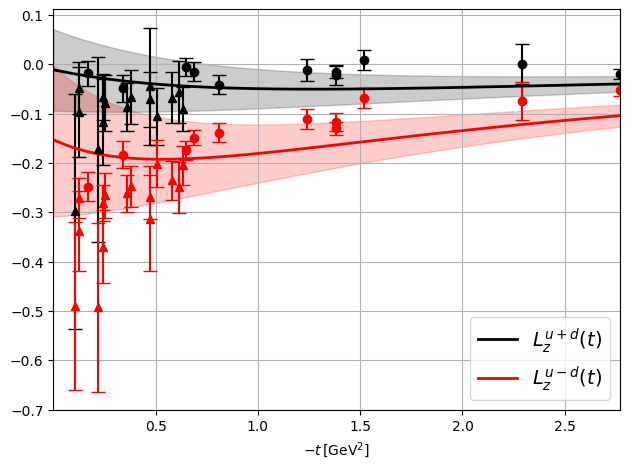

In [1]:
from stringy_gpds.core import plot_orbital_angular_momentum
plot_orbital_angular_momentum(0,2,evolution_order="nlo")

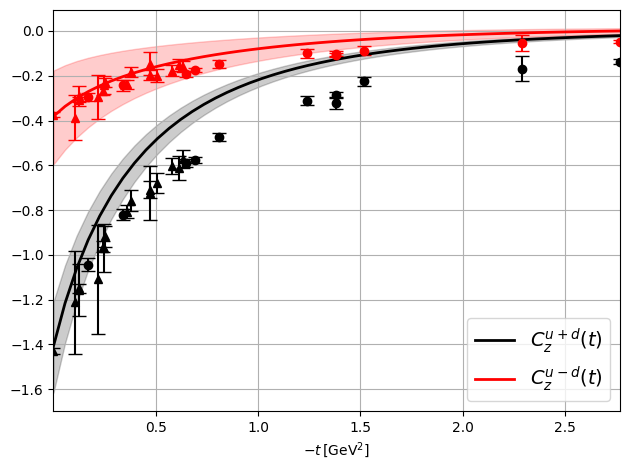

In [1]:
from stringy_gpds.core import plot_spin_orbit_correlation
plot_spin_orbit_correlation(0,2,evolution_order="nlo")